#1. Introduction

This colab provides the code for Crossvalidation to asses the performance of the BERT base cased model. This version is **stable**. The files you will need for this colab are "PETv1.1-entities.jsonl" and "complete_combined_leschneiderdata_NER.jsonl". The paths of which you need to specify.

##1.1 Preliminary Code

The code below provides the necesary libraries, paths to the input data and initial variable setups.

In [ ]:
#@title Importing and setting variables
import torch
import json
from transformers import BertTokenizer, BertForTokenClassification
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import RobertaTokenizer, RobertaForTokenClassification
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from collections import defaultdict
from sklearn.metrics import precision_recall_fscore_support
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from google.colab import files
import random
import copy

# Set a fixed seed for all random operations
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# If you're using CUDA:
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # For multi-GPU setups
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


drive.mount('/content/drive/')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#setting up the tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

#Is needed for the translation between floats and labels, as BERT's output is a float.
label_map = {
    "O": 0,
    "B-Actor": 1, "I-Actor": 2,
    "B-Activity": 3, "I-Activity": 4,
    "B-Activity Data": 5, "I-Activity Data": 6,
    "B-Further Specification": 7, "I-Further Specification": 8,
    "B-XOR Gateway": 9, "I-XOR Gateway": 10,
    "B-Condition Specification": 11, "I-Condition Specification": 12,
    "B-AND Gateway": 13, "I-AND Gateway": 14
}

short_label_map = {
    "O": 0,
    "Actor": 1,
    "Activity": 2,
    "Activity Data": 3,
    "Further Specification": 4,
    "XOR Gateway": 5,
    "Condition Specification": 6,
    "AND Gateway": 7
}

# Reverse map for evaluation purposes
reverse_label_map = {v: k for k, v in label_map.items()}
NUM_LABELS = len(label_map)  # Correctly reflects the actual classification labels


Mounted at /content/drive/


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Constants, can be changed for model optimisation
MAX_LEN = 128  # Or any max length suited to your data
BATCH_SIZE = 8
EPOCHS = 7

In [ ]:
#@title Printing Model Output Code
def print_token_predictions_true_labels(val_dataloader, model, tokenizer, reverse_label_map, num_samples=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()  # Ensure the model is in evaluation mode
    samples_printed = 0

    for batch in val_dataloader:
        if samples_printed >= num_samples:
            break  # Stop once we've reached the desired number of samples

        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            logits = outputs.logits

        # Convert logits to predicted label IDs
        preds = torch.argmax(logits, dim=2)

        for i in range(batch['input_ids'].size(0)):
            if samples_printed >= num_samples:
                break

            input_ids = batch['input_ids'][i].cpu().numpy()
            attention_mask = batch['attention_mask'][i].cpu().numpy()
            true_label_ids = batch['labels'][i].cpu().numpy()
            pred_label_ids = preds[i].cpu().numpy()

            # Decode the input IDs to tokens
            tokens = tokenizer.convert_ids_to_tokens(input_ids, skip_special_tokens=False)

            # Skip special tokens for true and predicted labels
            true_labels = [reverse_label_map[label_id] for label_id, mask in zip(true_label_ids, attention_mask) if mask == 1]
            pred_labels = [reverse_label_map[pred_id] for pred_id, mask in zip(pred_label_ids, attention_mask) if mask == 1]

            print(f"\nSample {samples_printed + 1}:")
            print("Tokens and Labels:")
            for token, true_label, pred_label in zip(tokens, true_labels, pred_labels):
                print(f"{token}\tTrue: {true_label}\tPred: {pred_label}")
            print("\n")

            samples_printed += 1


def print_token_true_labels_per_sentence_excluding_special_tokens(val_dataloader, model, tokenizer, reverse_label_map, num_samples=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device).eval()  # Move model to the correct device and set to evaluation mode

    samples_printed = 0

    for batch in val_dataloader:
        if samples_printed >= num_samples:
            break  # Stop after reaching the desired number of samples

        batch = {k: v.to(device) for k, v in batch.items()}  # Move batch to the correct device

        with torch.no_grad():
            outputs = model(**batch)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=2)

        for i in range(batch['input_ids'].size(0)):
            if samples_printed >= num_samples:
                break

            input_ids = batch['input_ids'][i].cpu().numpy()
            attention_mask = batch['attention_mask'][i].cpu().numpy()
            true_label_ids = batch['labels'][i].cpu().numpy()

            tokens = tokenizer.convert_ids_to_tokens(input_ids, skip_special_tokens=True)
            true_labels = [reverse_label_map[label_id] for label_id in true_label_ids]

            # Filter tokens and labels to exclude special tokens and corresponding labels
            filtered_tokens_and_labels = [
                (token, label) for token, label, mask in zip(tokens, true_labels, attention_mask)
                if mask == 1 and token not in tokenizer.all_special_tokens
            ]

            filtered_tokens = [token for token, _ in filtered_tokens_and_labels]
            filtered_true_labels = [label for _, label in filtered_tokens_and_labels]

            print(f"\nSample {samples_printed + 1}:")
            print("Tokens:")
            print(filtered_tokens)
            print("True Labels:")
            print(filtered_true_labels)
            print("\n")

            samples_printed += 1

# Ensure you have your val_dataloader, model, tokenizer, and reverse_label_map properly defined before calling this function.

def output_predictions_to_excel(val_dataloader, model, tokenizer, reverse_label_map, num_samples=5, file_name='output.xlsx'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device).eval()  # Ensure the model is in evaluation mode and moved to the right device
    samples_printed = 0

    # Prepare DataFrame
    columns = ['Token', 'True Label', 'Predicted Label']
    data = []

    for batch in val_dataloader:
        #if samples_printed >= num_samples:
            #break  # Stop once we've reached the desired number of samples

        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            logits = outputs.logits
        preds = torch.argmax(logits, dim=2)

        for i in range(batch['input_ids'].size(0)):
            #if samples_printed >= num_samples:
                #break

            input_ids = batch['input_ids'][i].cpu().numpy()
            attention_mask = batch['attention_mask'][i].cpu().numpy()
            true_label_ids = batch['labels'][i].cpu().numpy()
            pred_label_ids = preds[i].cpu().numpy()

            tokens = tokenizer.convert_ids_to_tokens(input_ids, skip_special_tokens=False)
            true_labels = [reverse_label_map[label_id] for label_id, mask in zip(true_label_ids, attention_mask) if mask == 1]
            pred_labels = [reverse_label_map[pred_id] for pred_id, mask in zip(pred_label_ids, attention_mask) if mask == 1]

            # Append each token and its labels to the data list
            data.extend([(token, true, pred) for token, true, pred in zip(tokens, true_labels, pred_labels)])

            samples_printed += 1

    # Create DataFrame and write to Excel
    file_path = f"/content/drive/MyDrive/THESIS/CODING/BERT outputs/BERT predictions/{file_name}"
    df = pd.DataFrame(data, columns=columns)
    df.to_excel(file_path, index=False)

    print(f"Output written to {file_path}")

# Ensure your model, tokenizer, and dataloader are properly initialized before calling this function.


In [ ]:
#@title Initialization of necessary functions for crossvalidation and training of BERT

#This function is grouping and loading data per doc-id such that they are processed per doc-id. The function expects a path to a .json file
def load_and_group_ner_data(file_path):
    grouped_data = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            entry = json.loads(line)
            document_name = entry['document name']  # Adjusted to use 'document name'
            if document_name not in grouped_data:
                grouped_data[document_name] = []
            grouped_data[document_name].append(entry)
            #print(entry)
    # Sort each group by 'sentence-ID'
    for doc in grouped_data.values():
        doc.sort(key=lambda x: x['sentence-ID'])

    return list(grouped_data.values())

#For the calculation of accuracy metrics
def calculate_f1(model, dataloader, device):
    model.eval()
    true_labels, pred_labels = [], []
    with torch.no_grad():
        check_true, check_pred = set(), set()
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)

            # Flatten labels and predictions
            batch_labels = batch['labels'].detach().cpu().numpy()
            batch_predictions = predictions.detach().cpu().numpy()

            true_labels.extend(batch_labels.flatten())
            pred_labels.extend(batch_predictions.flatten())
            check_true.update(true_labels)
            check_pred.update(pred_labels)


    # Calculate precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted', zero_division=0)
    return precision, recall, f1


#This class tokenizes the sentences and their words according to the predefined tokenizer for BERT. Also maps the labels to their integer number values.
class NERDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_len, label_map):
        self.sentences = sentences  # List of sentences (each sentence is a list of words)
        self.labels = labels        # List of label sequences corresponding to each sentence
        self.tokenizer = tokenizer  # BERT tokenizer
        self.max_len = max_len      # Maximum sequence length
        self.label_map = label_map  # Mapping from label strings to integers

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        words = self.sentences[idx]
        word_labels = self.labels[idx]

        # Tokenize words and align labels with tokens
        tokens = []
        aligned_labels = []
        for word, label in zip(words, word_labels):
            word_tokens = self.tokenizer.tokenize(word)
            tokens.extend(word_tokens)
            # Extend the label to all subwords
            aligned_labels.extend([label] * len(word_tokens))

        # Truncate tokens and labels if they exceed max_len
        tokens = tokens[:self.max_len-2]
        aligned_labels = aligned_labels[:self.max_len-2]

        # Convert tokens and labels to model inputs
        input_ids = self.tokenizer.convert_tokens_to_ids(['[CLS]'] + tokens + ['[SEP]'])
        attention_mask = [1] * len(input_ids)
        label_ids = [self.label_map['O']] + [self.label_map[label] for label in aligned_labels] + [self.label_map['O']]

        # Padding
        padding_length = self.max_len - len(input_ids)
        input_ids += [self.tokenizer.pad_token_id] * padding_length
        attention_mask += [0] * padding_length
        label_ids += [self.label_map['O']] * padding_length

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'labels': torch.tensor(label_ids, dtype=torch.long)
        }

#This function employs a BERT model training where no early stopping is used
def train_model(model, train_dataloader, val_dataloader, optimizer, scheduler, EPOCHS, label_map, checkpoint_dir='./model_checkpoints'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Directory where you want to save your model checkpoints
    os.makedirs(checkpoint_dir, exist_ok=True)

    #Initialize score
    best_f1_score = 0.0

    #In order to plot the validation and training losses to check for overfitting
    training_losses = []
    validation_losses = []

    for epoch_i in range(EPOCHS):
        print(f'Epoch {epoch_i + 1}/{EPOCHS}')
        print("Training...")
        model.train()
        total_train_loss = 0

        for step, batch in enumerate(train_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            model.zero_grad()
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            total_train_loss += loss.item()
            optimizer.step()
            scheduler.step()

            if step % 100 == 0 or step == len(train_dataloader) - 1:
                precision, recall, f1 = calculate_f1(model, val_dataloader, device)
                print(f"Step {step}, Loss: {loss.item():.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

        avg_train_loss = total_train_loss / len(train_dataloader)
        print(f'Average training loss: {avg_train_loss:.4f}\n')

        training_losses.append(avg_train_loss)

        # In each epoch we validate the current model so to get the Validation Loss for plotting.
        val_metrics = evaluate_model(model, val_dataloader, label_map)
        validation_losses.append(val_metrics['avg_val_loss'])

    return model, training_losses, validation_losses

#This function employs a BERT model training where early stopping is used
def train_model_with_early_stopping(model, train_dataloader, val_dataloader, optimizer, scheduler, EPOCHS, patience, checkpoint_dir='./model_checkpoints'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    os.makedirs(checkpoint_dir, exist_ok=True)
    best_f1_score = 0.0
    patience_counter = 0

    for epoch_i in range(EPOCHS):
        print(f'Epoch {epoch_i + 1}/{EPOCHS}')
        model.train()
        total_train_loss = 0

        for step, batch in enumerate(train_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            model.zero_grad()
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            total_train_loss += loss.item()
            optimizer.step()
            scheduler.step()

        precision, recall, f1 = calculate_f1(model, val_dataloader, device)
        print(f"Epoch {epoch_i + 1}, Validation Precision: {precision}, Recall: {recall}, F1: {f1}")

        if f1 > best_f1_score:
            best_f1_score = f1
            patience_counter = 0
            torch.save(model.state_dict(), os.path.join(checkpoint_dir, 'best_model.pth'))
            print("Validation F1 Score improved. Saving model checkpoint.")
        else:
            patience_counter += 1
            print("Validation F1 Score did not improve.")

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

        print(f'Epoch {epoch_i + 1} completed.\n')

    # Load the best model after training ends
    model.load_state_dict(torch.load(os.path.join(checkpoint_dir, 'best_model.pth')))



In [ ]:
#@title convert_IOB2_to_chunks
def convert_IOB2_to_chunks(nested_label_list, reverse_label_map):

    all_chunks = []
    #print(nested_label_list)
    for sentence in nested_label_list:
        #print(sentence)
        chunks = []
        current_chunk = []
        current_type = None

        for idx, label_idx in enumerate(sentence):
            label = reverse_label_map[label_idx]

            if label.startswith('B-'):
                if current_chunk:
                    chunks.append((current_type, current_chunk))
                    current_chunk = []
                current_type = label[2:]
                current_chunk = [idx, idx]  # Start a new chunk

            elif label.startswith('I-') and current_type == label[2:]:
                current_chunk[1] = idx  # Extend the current chunk

            elif label == 'O':
                if current_chunk:  # End current chunk before starting 'O' chunk
                    chunks.append((current_type, current_chunk))
                current_type = 'O'
                current_chunk = [idx, idx]  # Start a new 'O' chunk immediately


            else:  # For non-matching 'I-' or different entity types
                if current_chunk:
                    chunks.append((current_type, current_chunk))
                    current_chunk = []
                current_type = None

        if current_chunk:  # Add the last chunk if exists
            chunks.append((current_type, current_chunk))

        all_chunks.append(chunks)

    return all_chunks

In [ ]:
#@title Evaluation helper functions
def calculate_metrics_per_sentence_by_label(true_chunks_all_sentences, pred_chunks_all_sentences):
    # Initialize counters for true positives, false positives, and false negatives per label
    tp_dict = defaultdict(int)
    fp_dict = defaultdict(int)
    fn_dict = defaultdict(int)
    support_dict = defaultdict(int)

    labels = set(label for sentence in true_chunks_all_sentences + pred_chunks_all_sentences for label, _ in sentence)

    #For the calculation of support
    for true_chunks in true_chunks_all_sentences:
        for label, _ in true_chunks:
            support_dict[label] += 1

    #For the calculation of precision, recall and F1
    for true_chunks, pred_chunks in zip(true_chunks_all_sentences, pred_chunks_all_sentences):
        true_set = set((label, tuple(indices)) for label, indices in true_chunks)
        pred_set = set((label, tuple(indices)) for label, indices in pred_chunks)

        # True Positives per label
        for label, indices in true_set & pred_set:
            tp_dict[label] += 1

        # False Positives per label
        for label, indices in pred_set - true_set:
            fp_dict[label] += 1

        # False Negatives per label
        for label, indices in true_set - pred_set:
            fn_dict[label] += 1

    # Calculate metrics per label
    metrics_per_label = {}
    for label in labels:
        tp = tp_dict[label]
        fp = fp_dict[label]
        fn = fn_dict[label]
        precision = tp / (tp + fp) if tp + fp > 0 else 0
        recall = tp / (tp + fn) if tp + fn > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
        support = support_dict[label]

        metrics_per_label[label] = {
            "Precision": precision,
            "Recall": recall,
            "F1": f1,
            "Support": support,
            "TP": tp,
            "FP": fp,
            "FN": fn
        }

    return metrics_per_label

def calculate_macro_averaged_f1(metrics_per_label):
    f1_scores = [metrics['F1'] for metrics in metrics_per_label.values()]
    macro_averaged_f1 = sum(f1_scores) / len(f1_scores) if f1_scores else 0
    return macro_averaged_f1

def calculate_micro_f1(metrics_per_label):
    # Initialize counters for total TP, FP, and FN
    total_tp = 0
    total_fp = 0
    total_fn = 0

    # Iterate through each label in the metrics_per_label dictionary
    for label, metrics in metrics_per_label.items():
        # Extract the TP, FP, and FN for the current label
        tp = metrics["TP"]
        fp = metrics["FP"]
        fn = metrics["FN"]

        # Accumulate the total TP, FP, and FN
        total_tp += tp
        total_fp += fp
        total_fn += fn

    # Calculate micro precision and recall
    if (total_tp + total_fp) > 0:
        micro_precision = total_tp / (total_tp + total_fp)
    else:
        micro_precision = 0

    if (total_tp + total_fn) > 0:
        micro_recall = total_tp / (total_tp + total_fn)
    else:
        micro_recall = 0

    # Calculate micro F1 score
    if (micro_precision + micro_recall) > 0:
        micro_f1 = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall)
    else:
        micro_f1 = 0

    return micro_f1

def calculate_weighted_f1(metrics_per_label):

    # Initialize variables for the sum of weighted F1 scores and the total support
    weighted_f1_sum = 0
    total_support = 0

    # Iterate through each label in the metrics_per_label dictionary
    for label, metrics in metrics_per_label.items():
        # Extract the F1 score and support for the current label
        f1_score = metrics["F1"]
        support = metrics["Support"]

        # Add the product of the current label's F1 score and its support to the sum of weighted F1 scores
        weighted_f1_sum += f1_score * support

        # Add the current label's support to the total support
        total_support += support

    # Calculate the overall weighted F1 score by dividing the sum of weighted F1 scores by the total support
    if total_support > 0:
        overall_weighted_f1 = weighted_f1_sum / total_support
    else:
        overall_weighted_f1 = 0

    return overall_weighted_f1

def convert_int_2string(nested_label_list, reverse_label_map):

    all_chunks = []

    for sentence in nested_label_list:
        chunks = []
        current_chunk = []
        current_label = None

        for idx, label_idx in enumerate(sentence):
            label = reverse_label_map[label_idx]

            if current_label is None or current_label != label:
                if current_chunk:
                    chunks.append((current_label, current_chunk))
                current_label = label
                current_chunk = [idx, idx]
            else:
                current_chunk[1] = idx

        if current_chunk:
            chunks.append((current_label, current_chunk))

        all_chunks.append(chunks)

    return all_chunks


def get_sorted_labels(val_metrics):

    pairs = []
    non_paired_labels = []

    for label in sorted(val_metrics['detailed_metrics'].keys()):  # Sort keys to maintain alphabetical order
        if label.startswith("B-"):
            corresponding_i_label = f"I-{label[2:]}"
            if corresponding_i_label in val_metrics['detailed_metrics']:
                pairs.append((label, corresponding_i_label))
            else:
                non_paired_labels.append(label)  # Add B- label if I- counterpart not found
        elif not label.startswith("I-"):  # This will automatically handle 'O' and other non B-/I- labels
            non_paired_labels.append(label)

    # Flatten the sorted pairs
    sorted_labels = [label for pair in pairs for label in pair]

    # Add non-paired labels at the end
    sorted_labels.extend(non_paired_labels)

    return sorted_labels




The next functions are used for model evaluation

In [ ]:
#@title Main Evaluation function & Plotting
def evaluate_model(model, val_dataloader, label_map):
    # Set the device to GPU if available, else CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Switch the model to evaluation mode to disable dropout layers
    model.eval()

    # Initialize variables to accumulate loss and store predictions and true labels
    eval_loss = 0
    nb_eval_steps = 0
    true_labels = []
    pred_labels = []

    # Iterate over batches in the validation dataloader
    for batch in val_dataloader:
        # Move batch data to the same device as the model
        batch = {k: v.to(device) for k, v in batch.items()}

        # Perform inference (forward pass) without computing gradients
        with torch.no_grad():
            outputs = model(**batch)
            logits = outputs.logits
            eval_loss += outputs.loss.item()

        # Convert logits to predicted class indices
        preds = np.argmax(logits.detach().cpu().numpy(), axis=2)

        # Collect true and predicted labels for each sentence in the batch
        for i in range(batch["input_ids"].shape[0]):
            # Use attention mask to filter out padding tokens
            mask = batch["attention_mask"][i].cpu().numpy()
            true_sequence = batch["labels"][i].cpu().numpy()[mask == 1]
            pred_sequence = preds[i][mask == 1]

            # Append individual sentence-level lists
            true_labels.append(true_sequence.tolist())  # Convert to list for consistency
            pred_labels.append(pred_sequence.tolist())

        nb_eval_steps += 1

    #Then passed it through a function that converts the predictions into entities and at the same time from a integer to a string. We do this for the True and Predicted labels altogether
    #We get something like ['Actor', [1, 3]]
    #true_labels_entities = convert_IOB2_to_chunks(true_labels, reverse_label_map)
    #pred_labels_entities = convert_IOB2_to_chunks(pred_labels, reverse_label_map)

    true_labels_entities = convert_int_2string(true_labels, reverse_label_map)
    pred_labels_entities = convert_int_2string(pred_labels, reverse_label_map)
    #print(f"after {true_labels_entities}")
    #print(f"before {pred_labels_entities}")


    #We calculate metrics per label
    #label_metrics = compare_entities(true_labels_entities, pred_labels_entities)
    label_metrics = calculate_metrics_per_sentence_by_label(true_labels_entities, pred_labels_entities)

    #The averaged F1 where you treat each class equally without considering the labels frequency.
    macro_averaged_f1 = calculate_macro_averaged_f1(label_metrics)
    print(f"Macro-Averaged F1 Score: {macro_averaged_f1:.4f}\n")

    micro_average_f1 = calculate_micro_f1(label_metrics)
    print(f"Micro-Averaged F1 Score: {micro_average_f1:.4f}\n")

    #The weighted F1 accounts for the frequency in which a label occurs
    weighted_average_f1 = calculate_weighted_f1(label_metrics)
    print(f"Weigthed-Averaged F1 Score: {weighted_average_f1:.4f}\n")

    # Calculate average validation loss
    avg_val_loss = eval_loss / nb_eval_steps

    # Print average validation loss
    #print(f"Validation Loss: {avg_val_loss}\n")

    detailed_metrics = {}
    # Print metrics per label and aggregate them into detailed_metrics dictionary
    for label, metrics in label_metrics.items():
      precision = metrics['Precision']
      recall = metrics['Recall']
      f1 = metrics['F1']
      support = metrics['Support']

      detailed_metrics[label] = {
          'precision': precision,
          'recall': recall,
          'f1': f1,
          'support': support}

    # Return a dictionary with detailed metrics per label, weighted F1 score, and average validation loss
    return {
        'detailed_metrics': detailed_metrics,
        'macro_averaged_f1': macro_averaged_f1,
        'micro_averaged_f1': micro_average_f1,
        'weighted_average_f1': weighted_average_f1,
        'avg_val_loss': avg_val_loss
    }



#This function returns a confusion matrix between the true and predicted labels
def plot_confusion_matrix(true_labels, pred_labels, reverse_label_map):

    """
    Plots a confusion matrix using true and predicted labels.

    Parameters:
    - true_labels: List of true labels
    - pred_labels: List of predicted labels
    - reverse_label_map: Dictionary mapping label IDs back to string representations
    """

    # Convert label IDs back to their string representations
    true_labels_str = [reverse_label_map[label] for label in true_labels]
    pred_labels_str = [reverse_label_map[label] for label in pred_labels]

    # Generate the confusion matrix
    cm = confusion_matrix(true_labels_str, pred_labels_str, labels=list(reverse_label_map.values()))

    # Visualization
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(reverse_label_map.values()), yticklabels=list(reverse_label_map.values()))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

#This plot shows the overfitting of our model
def plot_losses(training_losses, validation_losses):
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(training_losses) + 1)
    plt.plot(epochs, training_losses, label='Training Loss')
    plt.plot(epochs, validation_losses, label='Validation Loss', linestyle="--")

    #Find the minimum validation loss and its corresponding epoch
    min_val_loss = min(validation_losses)
    min_val_loss_epoch = validation_losses.index(min_val_loss) + 1  # Adding 1 because epochs start at 1

    # Draw a horizontal line at the minimum validation loss
    plt.axhline(y=min_val_loss, color='r', linestyle='--', label=f'Min Validation Loss: {min_val_loss:.4f}')

    # Draw a vertical line at the epoch of the minimum validation loss
    plt.axvline(x=min_val_loss_epoch, color='g', linestyle='--', label=f'Epoch: {min_val_loss_epoch}')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(visible=True)
    plt.show()



Below is the core function for the crossvalidation. **To adjust the model**, uncomment and comment the "model" from line 61.

In [ ]:
#@title Crossvalidation Function
#This code performs the cross_validation and trains the model n times.
def grouped_k_fold_cross_validation(data, splits: int(), batch_size, EPOCHS, label_map, learning_rate):


    # Step 1: Prepare group IDs for GroupKFold using the training+validation data
    # Recalculate group IDs to reflect only the groups within train_val_data
    unique_docs = set(item['document name'] for item in data)
    doc_to_id = {doc_name: i for i, doc_name in enumerate(unique_docs)}
    group_ids = [doc_to_id[item['document name']] for item in data]

    # Step 2: Initializing GroupKFold Crossvalidation
    gkf = GroupKFold(n_splits=splits)

    #In order to compute an aggregate result through all folds at the end we need to keep a list.
    all_fold_results = []
    # Initialize a dictionary to accumulate F1 scores for each label across folds
    label_f1_scores = {label: [] for label in label_map.keys()}
    label_P_scores = {label: [] for label in label_map.keys()}
    label_R_scores = {label: [] for label in label_map.keys()}

    # To chose the best performing model
    models_and_metrics = {}

    for fold, (train_idx, val_idx) in enumerate(gkf.split(X=data, groups=group_ids)):
        print(f"Fold {fold+1}")

        #We split the entire dataset based on train_idx and val_idx given by the GroupKFold module.
        #It ensures no two identical groups are presented as a validation set twice.
        train_subset = Subset(data, indices=train_idx)
        val_subset = Subset(data, indices=val_idx)

        # Instantiate the dataset and dataloader for training
        train_dataset = NERDataset(
            sentences=[entry['tokens'] for entry in train_subset],
            labels=[entry['ner-tags'] for entry in train_subset],
            tokenizer=tokenizer,
            max_len=MAX_LEN,
            label_map=label_map
        )

        # Instantiate the dataset and dataloader for validation
        val_dataset = NERDataset(
            sentences=[entry['tokens'] for entry in val_subset],
            labels=[entry['ner-tags'] for entry in val_subset],
            tokenizer=tokenizer,
            max_len=MAX_LEN,
            label_map=label_map
        )

        #Initialize the DataLoader objects
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

        #loading the desired model: each fold we need start fresh
        model = BertForTokenClassification.from_pretrained("bert-base-cased", num_labels=NUM_LABELS)

        # Fine-tuning setup, can be changed for model optimisation
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, eps=1e-8)
        total_steps = len(train_loader) * EPOCHS
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

        # Using funtion defined above to train the model and obtain the losses for plotting at the same time
        model, training_losses, validation_losses = train_model(model, train_loader, val_loader, optimizer, scheduler, EPOCHS, label_map, checkpoint_dir='./model_checkpoints')
        plot_losses(training_losses,validation_losses)

        #Evaluating the model in this fold
        val_metrics = evaluate_model(model, val_loader, label_map)

        all_fold_results.append(val_metrics)

        models_and_metrics[fold] = {
        "model": model,
        "val_metrics": val_metrics}

        # Open a file for output
        header = "{:<35} {:<10} {:<10} {:<10} {:<10}\n".format("Label", "Precision", "Recall", "F1", "Support")
        row_format = "{:<35} {:<10} {:<10} {:<10} {:<10}\n"
        print(header)

        # Call the function to get the sorted labels
        sorted_labels = get_sorted_labels(val_metrics)

        for label in sorted_labels:
            metrics = val_metrics['detailed_metrics'][label]
            print(row_format.format(label, "{:.4f}".format(metrics['precision']), "{:.4f}".format(metrics['recall']), "{:.4f}".format(metrics['f1']), "{:.0f}".format(metrics['support'])))
            label_f1_scores[label].append(metrics['f1'])
            label_P_scores[label].append(metrics['precision'])
            label_R_scores[label].append(metrics['recall'])

        print("SUMMARY FOLD: \n")
        print(f"Macro Averaged F1 Score for fold {fold+1}: {val_metrics['macro_averaged_f1']:.4f}\n")
        print(f"Micro Averaged F1 Score for fold {fold+1}: {val_metrics['micro_averaged_f1']:.4f}\n")
        print(f"Weighted Averaged F1 Score for fold {fold+1}: {val_metrics['weighted_average_f1']:.4f}\n")

        #output_predictions_to_excel(val_loader, model, tokenizer, reverse_label_map, num_samples=5, file_name=f'output_fold{fold}.xlsx')
        #print_token_true_labels_per_sentence(val_loader, model, tokenizer, reverse_label_map, num_samples=2)
        #break

    # Save the best model
    best_fold = max(
        models_and_metrics,
        key=lambda x: models_and_metrics[x]["val_metrics"]["macro_averaged_f1"])

    best_model = models_and_metrics[best_fold]["model"]
    best_model_metrics = models_and_metrics[best_fold]["val_metrics"]

    # Initialize a variable to accumulate weighted F1 scores from each fold
    total_macro_f1 = 0
    total_micro_f1 = 0
    total_weighted_f1 = 0

    # Assuming you're still appending the results of evaluate_model to all_fold_results
    for results in all_fold_results:
        total_macro_f1 += results['macro_averaged_f1']
        total_micro_f1 += results['micro_averaged_f1']
        total_weighted_f1 += results['weighted_average_f1']

    # Calculate the average weighted F1 score across all folds
    print("---------------------------------------")
    print("\nTraining succesfully finished!\n")
    print("---------------------------------------\n")
    print("---------------------------------------")
    print(f"Best fold was fold {best_fold+1}\n")
    print("---------------------------------------\n")
    average_macro_f1 = total_macro_f1 / len(all_fold_results)
    average_micro_f1 = total_micro_f1 / len(all_fold_results)
    average_weighted_f1 = total_weighted_f1 / len(all_fold_results)
    print(f"Average Macro F1 Score Across All Folds: {average_macro_f1:.4f}")
    print(f"Average Micro F1 Score Across All Folds: {average_micro_f1:.4f}")
    print(f"Average Weighted F1 Score Across All Folds: {average_weighted_f1:.4f}")

    # Calculate and print average F1 scores, precision, and recall for each label across all folds
    row_format = "{:<35} {:<10} {:<10} {:<10}\n"
    print("Average Metrics per Label:\n")
    print(row_format.format("Label", "Precision", "Recall", "F1"))
    for label in sorted_labels:
        try:
            average_f1 = sum(label_f1_scores[label]) / len(label_f1_scores[label])
            average_precision = sum(label_P_scores[label]) / len(label_P_scores[label])
            average_recall = sum(label_R_scores[label]) / len(label_R_scores[label])
            print(row_format.format(label, "{:.4f}".format(average_precision), "{:.4f}".format(average_recall), "{:.4f}".format(average_f1)))
        except ZeroDivisionError:
            print(f"Zero division error for label {label}")

    return best_model, average_macro_f1, average_micro_f1, average_weighted_f1, label_f1_scores


Now that all functions have been initialized we can start calling them.

##1.2 Data Loading

First we need to load the data, since our combined data is in two seperate files we need to merge them first. Then, we need to tokenize (which happens in the groupfold function) and prepare the data so the model can understand it.

In [ ]:
#setting up the input data and merging them
#adjust according to dataset location
try:
  PET_Folder = '/content/drive/MyDrive/THESIS/DATA/PET/actual PET data from Patrizio Bellan/PETv1.1-entities.jsonl'
  LESCHNEIDER_Folder = '/content/drive/MyDrive/THESIS/DATA/LESCHNEIDER DATA/Documents/FORMATTED_DATA_ELEMENTS/complete_combined_leschneiderdata_NER.jsonl'

  # Load and group data from both files calling on a function above
  grouped_data_1 = load_and_group_ner_data(PET_Folder)
  grouped_data_2 = load_and_group_ner_data(LESCHNEIDER_Folder)

  # Append the contents of the second list to the first
  unflattened_data = grouped_data_1 + grouped_data_2 #Combined data

  #Because the data is grouped according to doc_name, the unflattened_data is a list that contains lists. By unpacking we create a list containing not lists but the actual documents.
  input_data = [item for group in unflattened_data for item in group] #Now input_data containts all the sentences.
  if input_data:
    print("Data Loaded")
    print(f"sample data: {input_data}")
except FileNotFoundError as fnf:
  print("File was not found or incorrect file directory, please try to run cell again")



Data Loaded
sample data: [{'document name': 'doc-10.1', 'sentence-ID': 0, 'tokens': ['The', 'MPON', 'sents', 'the', 'dismissal', 'to', 'the', 'MPOO', '.'], 'ner-tags': ['B-Actor', 'I-Actor', 'B-Activity', 'B-Activity Data', 'I-Activity Data', 'O', 'B-Actor', 'I-Actor', 'O']}, {'document name': 'doc-10.1', 'sentence-ID': 1, 'tokens': ['The', 'MPOO', 'reviews', 'the', 'dismissal', '.'], 'ner-tags': ['B-Actor', 'I-Actor', 'B-Activity', 'B-Activity Data', 'I-Activity Data', 'O']}, {'document name': 'doc-10.1', 'sentence-ID': 2, 'tokens': ['The', 'MPOO', 'opposes', 'the', 'dismissal', 'of', 'MPON', 'or', 'the', 'MPOO', 'confirmes', 'the', 'dismissal', 'of', 'the', 'MPON', '.'], 'ner-tags': ['B-Actor', 'I-Actor', 'B-Activity', 'B-Activity Data', 'I-Activity Data', 'O', 'O', 'B-XOR Gateway', 'B-Actor', 'I-Actor', 'B-Activity', 'B-Activity Data', 'I-Activity Data', 'O', 'O', 'O', 'O']}, {'document name': 'doc-10.12', 'sentence-ID': 0, 'tokens': ['The', 'EC', 'tells', 'the', 'INQ', 'about', 'th

#2 Model Training & Learning Rate Evaluation

Now we will train the model using Grouped K Crossvalidation for each Learning Rate. Make sure you ran all cells before. **This will take a long time** depending on your configuration and computing power. Here we evaluate the learning rate, we conclude that a learning rate of 5e-5performs best together with an epoch of 5.


---------------------------------------
Learning Rate: 2e-05
---------------------------------------

Fold 1


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.7429, Precision: 0.8936, Recall: 0.2551, F1: 0.3948
Step 50, Loss: 0.2534, Precision: 0.9171, Recall: 0.9380, F1: 0.9228
Average training loss: 0.6190

Macro-Averaged F1 Score: 0.1402

Micro-Averaged F1 Score: 0.3172

Weigthed-Averaged F1 Score: 0.2985

Epoch 2/7
Training...
Step 0, Loss: 0.2925, Precision: 0.9177, Recall: 0.9390, F1: 0.9250
Step 50, Loss: 0.2871, Precision: 0.9410, Recall: 0.9581, F1: 0.9488
Average training loss: 0.1741

Macro-Averaged F1 Score: 0.2965

Micro-Averaged F1 Score: 0.5557

Weigthed-Averaged F1 Score: 0.5377

Epoch 3/7
Training...
Step 0, Loss: 0.1642, Precision: 0.9426, Recall: 0.9588, F1: 0.9503
Step 50, Loss: 0.0806, Precision: 0.9507, Recall: 0.9646, F1: 0.9574
Average training loss: 0.1057

Macro-Averaged F1 Score: 0.4368

Micro-Averaged F1 Score: 0.6694

Weigthed-Averaged F1 Score: 0.6431

Epoch 4/7
Training...
Step 0, Loss: 0.0678, Precision: 0.9509, Recall: 0.9640, F1: 0.9571
Step 50, Loss: 0.0293, Precision: 

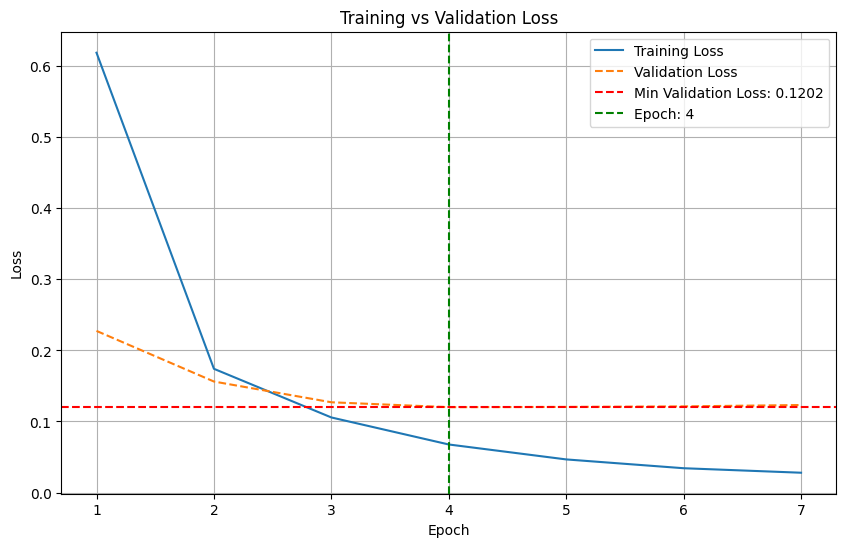

Macro-Averaged F1 Score: 0.4936

Micro-Averaged F1 Score: 0.7044

Weigthed-Averaged F1 Score: 0.6911

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     7         

I-AND Gateway                       0.0000     0.0000     0.0000     3         

B-Activity                          0.8195     0.8862     0.8516     123       

I-Activity                          1.0000     0.1818     0.3077     11        

B-Activity Data                     0.7909     0.7768     0.7838     112       

I-Activity Data                     0.6074     0.7736     0.6805     106       

B-Actor                             0.8200     0.8723     0.8454     94        

I-Actor                             0.6531     0.7711     0.7072     83        

B-Condition Specification           1.0000     0.6667     0.8000     9         

I-Condition Specification           0.8571     0.6667     0.7500     9         

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.7307, Precision: 0.8543, Recall: 0.1901, F1: 0.3077
Step 50, Loss: 0.2924, Precision: 0.8230, Recall: 0.9072, F1: 0.8630
Average training loss: 0.6119

Macro-Averaged F1 Score: 0.0028

Micro-Averaged F1 Score: 0.0163

Weigthed-Averaged F1 Score: 0.0136

Epoch 2/7
Training...
Step 0, Loss: 0.2208, Precision: 0.8230, Recall: 0.9072, F1: 0.8630
Step 50, Loss: 0.1940, Precision: 0.9318, Recall: 0.9475, F1: 0.9381
Average training loss: 0.2503

Macro-Averaged F1 Score: 0.2062

Micro-Averaged F1 Score: 0.4464

Weigthed-Averaged F1 Score: 0.4453

Epoch 3/7
Training...
Step 0, Loss: 0.2010, Precision: 0.9324, Recall: 0.9475, F1: 0.9386
Step 50, Loss: 0.0962, Precision: 0.9520, Recall: 0.9624, F1: 0.9557
Average training loss: 0.1661

Macro-Averaged F1 Score: 0.3045

Micro-Averaged F1 Score: 0.6378

Weigthed-Averaged F1 Score: 0.6270

Epoch 4/7
Training...
Step 0, Loss: 0.1475, Precision: 0.9524, Recall: 0.9628, F1: 0.9563
Step 50, Loss: 0.0604, Precision: 

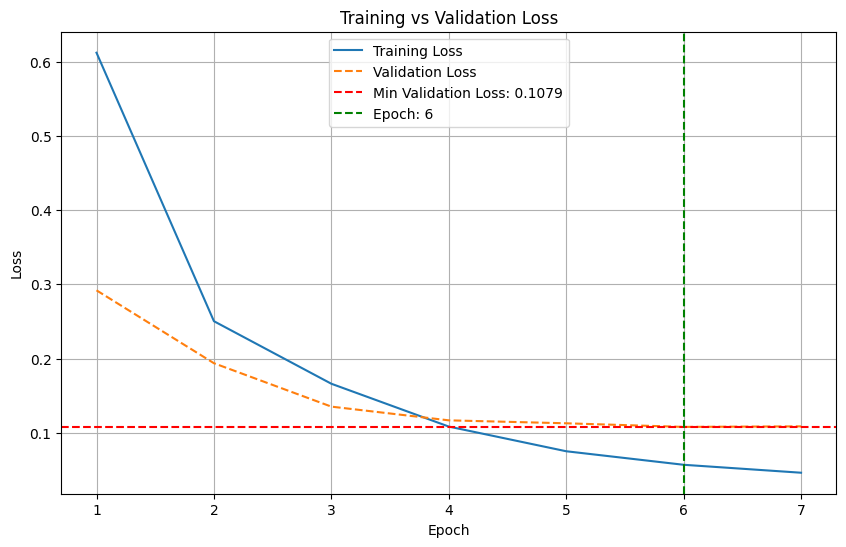

Macro-Averaged F1 Score: 0.4442

Micro-Averaged F1 Score: 0.7137

Weigthed-Averaged F1 Score: 0.7123

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     5         

I-AND Gateway                       0.0000     0.0000     0.0000     1         

B-Activity                          0.8760     0.8618     0.8689     123       

I-Activity                          1.0000     0.1250     0.2222     8         

B-Activity Data                     0.8362     0.8083     0.8220     120       

I-Activity Data                     0.6484     0.7477     0.6946     111       

B-Actor                             0.8017     0.7266     0.7623     128       

I-Actor                             0.6250     0.7080     0.6639     113       

B-Condition Specification           0.4615     0.5455     0.5000     11        

I-Condition Specification           0.1923     0.4545     0.2703     11        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.8726, Precision: 0.7945, Recall: 0.0545, F1: 0.0983
Step 50, Loss: 0.1901, Precision: 0.8906, Recall: 0.9279, F1: 0.9047
Average training loss: 0.6519

Macro-Averaged F1 Score: 0.0909

Micro-Averaged F1 Score: 0.1871

Weigthed-Averaged F1 Score: 0.1626

Epoch 2/7
Training...
Step 0, Loss: 0.1998, Precision: 0.8898, Recall: 0.9278, F1: 0.9038
Step 50, Loss: 0.1419, Precision: 0.9442, Recall: 0.9580, F1: 0.9475
Average training loss: 0.1877

Macro-Averaged F1 Score: 0.2798

Micro-Averaged F1 Score: 0.5865

Weigthed-Averaged F1 Score: 0.5518

Epoch 3/7
Training...
Step 0, Loss: 0.2061, Precision: 0.9445, Recall: 0.9581, F1: 0.9477
Step 50, Loss: 0.0669, Precision: 0.9603, Recall: 0.9611, F1: 0.9576
Average training loss: 0.1189

Macro-Averaged F1 Score: 0.3553

Micro-Averaged F1 Score: 0.6524

Weigthed-Averaged F1 Score: 0.6281

Epoch 4/7
Training...
Step 0, Loss: 0.1337, Precision: 0.9601, Recall: 0.9604, F1: 0.9572
Step 50, Loss: 0.1097, Precision: 

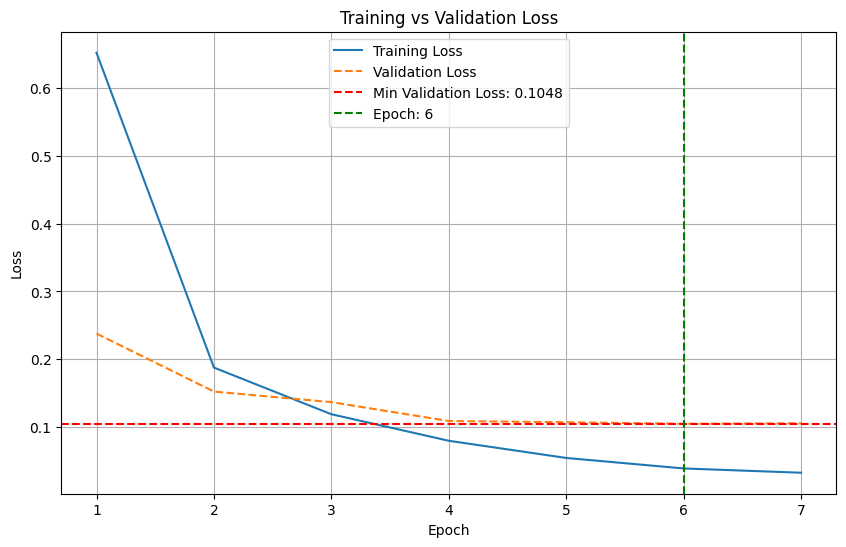

Macro-Averaged F1 Score: 0.5141

Micro-Averaged F1 Score: 0.7475

Weigthed-Averaged F1 Score: 0.7336

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     12        

I-AND Gateway                       0.0000     0.0000     0.0000     6         

B-Activity                          0.8028     0.9194     0.8571     124       

I-Activity                          1.0000     0.1667     0.2857     6         

B-Activity Data                     0.8264     0.8621     0.8439     116       

I-Activity Data                     0.6357     0.8119     0.7130     101       

B-Actor                             0.9118     0.9490     0.9300     98        

I-Actor                             0.8269     0.9247     0.8731     93        

B-Condition Specification           0.9333     0.6667     0.7778     21        

I-Condition Specification           0.5217     0.6000     0.5581     20        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.6878, Precision: 0.8859, Recall: 0.4845, F1: 0.6206
Step 50, Loss: 0.1554, Precision: 0.8950, Recall: 0.9251, F1: 0.9007
Average training loss: 0.5926

Macro-Averaged F1 Score: 0.0935

Micro-Averaged F1 Score: 0.1719

Weigthed-Averaged F1 Score: 0.1730

Epoch 2/7
Training...
Step 0, Loss: 0.2371, Precision: 0.8953, Recall: 0.9252, F1: 0.9009
Step 50, Loss: 0.1426, Precision: 0.9374, Recall: 0.9510, F1: 0.9394
Average training loss: 0.1821

Macro-Averaged F1 Score: 0.2474

Micro-Averaged F1 Score: 0.5064

Weigthed-Averaged F1 Score: 0.4795

Epoch 3/7
Training...
Step 0, Loss: 0.1623, Precision: 0.9373, Recall: 0.9511, F1: 0.9394
Step 50, Loss: 0.0961, Precision: 0.9472, Recall: 0.9566, F1: 0.9479
Average training loss: 0.1133

Macro-Averaged F1 Score: 0.2984

Micro-Averaged F1 Score: 0.5400

Weigthed-Averaged F1 Score: 0.5268

Epoch 4/7
Training...
Step 0, Loss: 0.1020, Precision: 0.9479, Recall: 0.9575, F1: 0.9491
Step 50, Loss: 0.0352, Precision: 

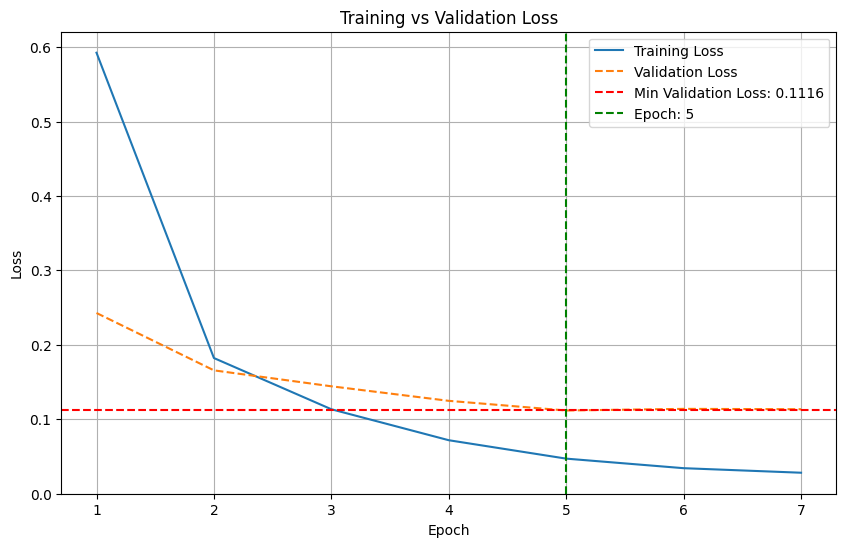

Macro-Averaged F1 Score: 0.5033

Micro-Averaged F1 Score: 0.6797

Weigthed-Averaged F1 Score: 0.6747

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     8         

I-AND Gateway                       0.0000     0.0000     0.0000     3         

B-Activity                          0.8833     0.8154     0.8480     130       

I-Activity                          0.0000     0.0000     0.0000     13        

B-Activity Data                     0.7890     0.7679     0.7783     112       

I-Activity Data                     0.5772     0.6893     0.6283     103       

B-Actor                             0.8713     0.8148     0.8421     108       

I-Actor                             0.7179     0.7671     0.7417     73        

B-Condition Specification           0.8750     0.5185     0.6512     27        

I-Condition Specification           0.3421     0.5200     0.4127     25        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.8244, Precision: 0.7288, Recall: 0.0652, F1: 0.1062
Step 50, Loss: 0.2594, Precision: 0.8984, Recall: 0.9217, F1: 0.9004
Average training loss: 0.5938

Macro-Averaged F1 Score: 0.0920

Micro-Averaged F1 Score: 0.2095

Weigthed-Averaged F1 Score: 0.1906

Epoch 2/7
Training...
Step 0, Loss: 0.2647, Precision: 0.9004, Recall: 0.9234, F1: 0.9036
Step 50, Loss: 0.2253, Precision: 0.9432, Recall: 0.9518, F1: 0.9445
Average training loss: 0.1875

Macro-Averaged F1 Score: 0.2659

Micro-Averaged F1 Score: 0.5659

Weigthed-Averaged F1 Score: 0.5383

Epoch 3/7
Training...
Step 0, Loss: 0.1469, Precision: 0.9449, Recall: 0.9520, F1: 0.9442
Step 50, Loss: 0.0680, Precision: 0.9515, Recall: 0.9614, F1: 0.9561
Average training loss: 0.1122

Macro-Averaged F1 Score: 0.3508

Micro-Averaged F1 Score: 0.6598

Weigthed-Averaged F1 Score: 0.6365

Epoch 4/7
Training...
Step 0, Loss: 0.1055, Precision: 0.9579, Recall: 0.9616, F1: 0.9566
Step 50, Loss: 0.1243, Precision: 

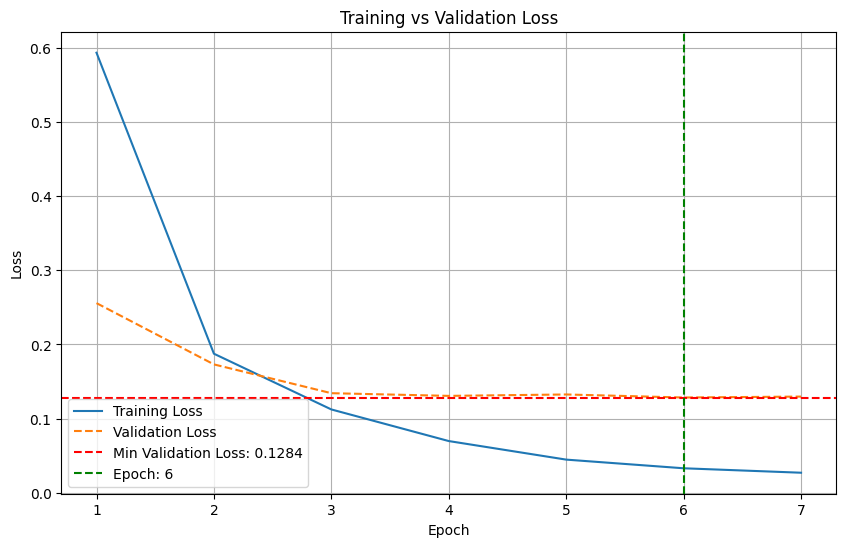

Macro-Averaged F1 Score: 0.4580

Micro-Averaged F1 Score: 0.7015

Weigthed-Averaged F1 Score: 0.6960

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     8         

I-AND Gateway                       0.0000     0.0000     0.0000     6         

B-Activity                          0.7941     0.9558     0.8675     113       

I-Activity                          0.0000     0.0000     0.0000     6         

B-Activity Data                     0.7538     0.9074     0.8235     108       

I-Activity Data                     0.5581     0.7742     0.6486     93        

B-Actor                             0.8160     0.8947     0.8536     114       

I-Actor                             0.6935     0.8958     0.7818     96        

B-Condition Specification           0.6957     0.5333     0.6038     30        

I-Condition Specification           0.2979     0.4667     0.3636     30        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.8289, Precision: 0.8341, Recall: 0.4033, F1: 0.5413
Step 50, Loss: 0.2064, Precision: 0.9268, Recall: 0.9451, F1: 0.9329
Average training loss: 0.4949

Macro-Averaged F1 Score: 0.2297

Micro-Averaged F1 Score: 0.4160

Weigthed-Averaged F1 Score: 0.4115

Epoch 2/7
Training...
Step 0, Loss: 0.1758, Precision: 0.9246, Recall: 0.9434, F1: 0.9300
Step 50, Loss: 0.1215, Precision: 0.9536, Recall: 0.9587, F1: 0.9514
Average training loss: 0.1363

Macro-Averaged F1 Score: 0.4178

Micro-Averaged F1 Score: 0.6107

Weigthed-Averaged F1 Score: 0.5909

Epoch 3/7
Training...
Step 0, Loss: 0.1719, Precision: 0.9541, Recall: 0.9592, F1: 0.9518
Step 50, Loss: 0.0564, Precision: 0.9565, Recall: 0.9634, F1: 0.9565
Average training loss: 0.0729

Macro-Averaged F1 Score: 0.4568

Micro-Averaged F1 Score: 0.6488

Weigthed-Averaged F1 Score: 0.6339

Epoch 4/7
Training...
Step 0, Loss: 0.1138, Precision: 0.9586, Recall: 0.9652, F1: 0.9595
Step 50, Loss: 0.0182, Precision: 

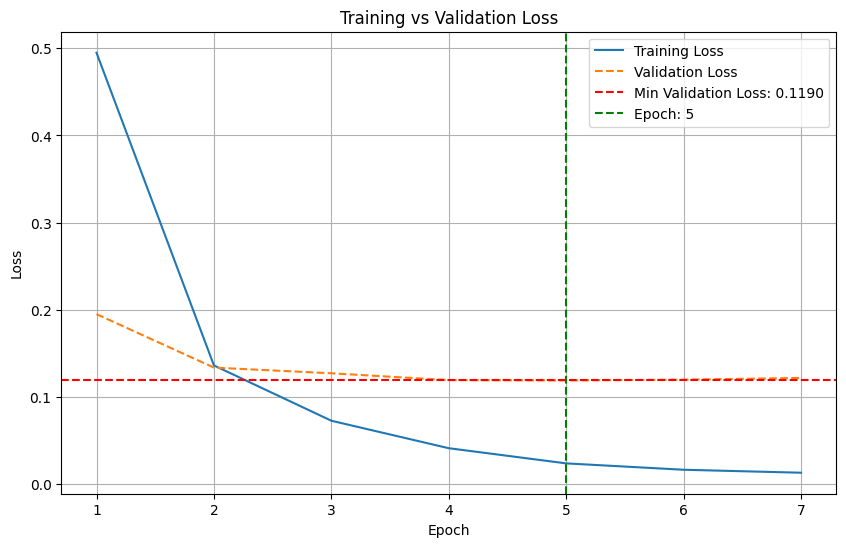

Macro-Averaged F1 Score: 0.5244

Micro-Averaged F1 Score: 0.6937

Weigthed-Averaged F1 Score: 0.6890

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       1.0000     0.1429     0.2500     7         

I-AND Gateway                       0.0000     0.0000     0.0000     3         

B-Activity                          0.8188     0.9187     0.8659     123       

I-Activity                          0.6667     0.1818     0.2857     11        

B-Activity Data                     0.7845     0.8125     0.7982     112       

I-Activity Data                     0.5481     0.6981     0.6141     106       

B-Actor                             0.8058     0.8830     0.8426     94        

I-Actor                             0.6117     0.7590     0.6774     83        

B-Condition Specification           1.0000     0.6667     0.8000     9         

I-Condition Specification           0.6364     0.7778     0.7000     9         

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.9735, Precision: 0.8382, Recall: 0.0366, F1: 0.0591
Step 50, Loss: 0.2394, Precision: 0.9374, Recall: 0.9502, F1: 0.9436
Average training loss: 0.5381

Macro-Averaged F1 Score: 0.2327

Micro-Averaged F1 Score: 0.5237

Weigthed-Averaged F1 Score: 0.5144

Epoch 2/7
Training...
Step 0, Loss: 0.2100, Precision: 0.9393, Recall: 0.9501, F1: 0.9443
Step 50, Loss: 0.0534, Precision: 0.9528, Recall: 0.9601, F1: 0.9552
Average training loss: 0.1445

Macro-Averaged F1 Score: 0.3211

Micro-Averaged F1 Score: 0.6555

Weigthed-Averaged F1 Score: 0.6488

Epoch 3/7
Training...
Step 0, Loss: 0.1091, Precision: 0.9556, Recall: 0.9618, F1: 0.9581
Step 50, Loss: 0.0453, Precision: 0.9630, Recall: 0.9658, F1: 0.9637
Average training loss: 0.0797

Macro-Averaged F1 Score: 0.4111

Micro-Averaged F1 Score: 0.6927

Weigthed-Averaged F1 Score: 0.6908

Epoch 4/7
Training...
Step 0, Loss: 0.0635, Precision: 0.9623, Recall: 0.9657, F1: 0.9631
Step 50, Loss: 0.0432, Precision: 

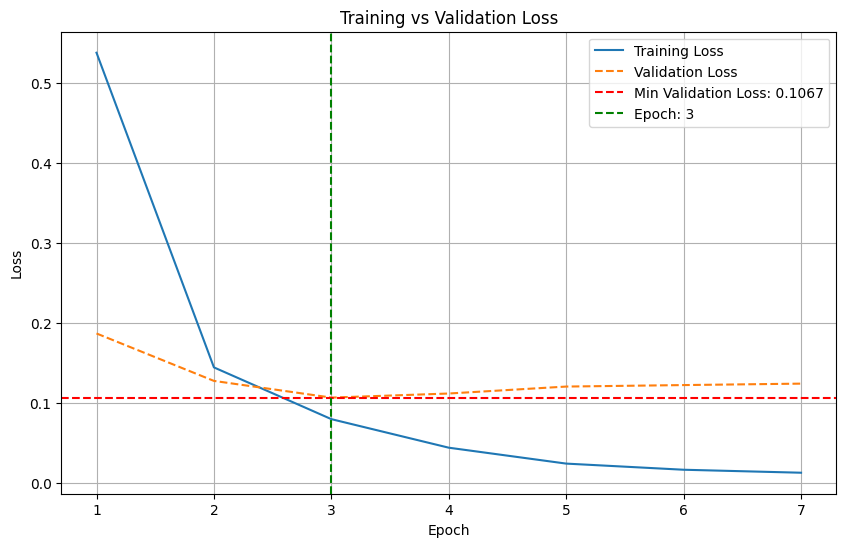

Macro-Averaged F1 Score: 0.5488

Micro-Averaged F1 Score: 0.7400

Weigthed-Averaged F1 Score: 0.7450

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       1.0000     0.2000     0.3333     5         

I-AND Gateway                       0.0000     0.0000     0.0000     1         

B-Activity                          0.9224     0.8699     0.8954     123       

I-Activity                          0.8571     0.7500     0.8000     8         

B-Activity Data                     0.8739     0.8083     0.8398     120       

I-Activity Data                     0.6721     0.7387     0.7039     111       

B-Actor                             0.7951     0.7578     0.7760     128       

I-Actor                             0.6612     0.7080     0.6838     113       

B-Condition Specification           0.3750     0.5455     0.4444     11        

I-Condition Specification           0.3333     0.6364     0.4375     11        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.8678, Precision: 0.8913, Recall: 0.0864, F1: 0.1441
Step 50, Loss: 0.3247, Precision: 0.8730, Recall: 0.9169, F1: 0.8814
Average training loss: 0.5301

Macro-Averaged F1 Score: 0.0119

Micro-Averaged F1 Score: 0.0467

Weigthed-Averaged F1 Score: 0.0402

Epoch 2/7
Training...
Step 0, Loss: 0.1981, Precision: 0.8740, Recall: 0.9175, F1: 0.8832
Step 50, Loss: 0.1799, Precision: 0.9436, Recall: 0.9566, F1: 0.9470
Average training loss: 0.2074

Macro-Averaged F1 Score: 0.3038

Micro-Averaged F1 Score: 0.5774

Weigthed-Averaged F1 Score: 0.5529

Epoch 3/7
Training...
Step 0, Loss: 0.1107, Precision: 0.9447, Recall: 0.9568, F1: 0.9479
Step 50, Loss: 0.0810, Precision: 0.9617, Recall: 0.9697, F1: 0.9646
Average training loss: 0.1230

Macro-Averaged F1 Score: 0.3589

Micro-Averaged F1 Score: 0.6911

Weigthed-Averaged F1 Score: 0.6661

Epoch 4/7
Training...
Step 0, Loss: 0.0923, Precision: 0.9614, Recall: 0.9694, F1: 0.9646
Step 50, Loss: 0.0129, Precision: 

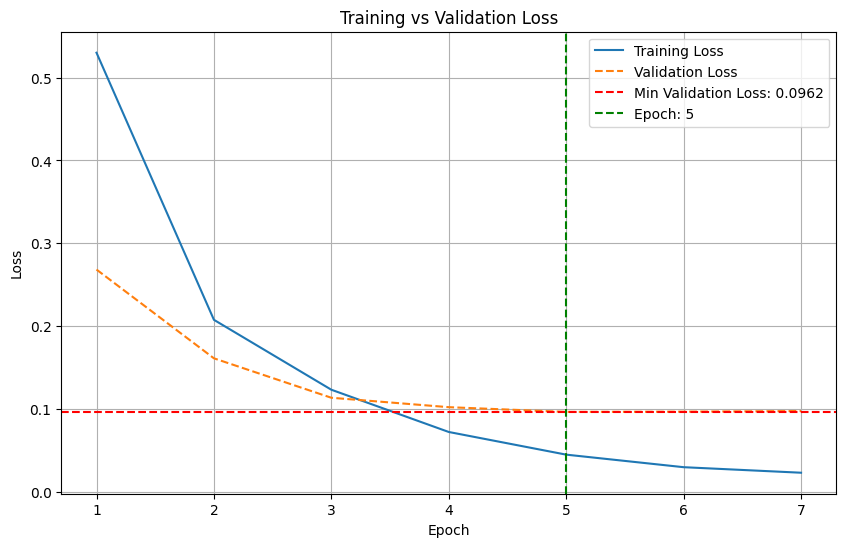

Macro-Averaged F1 Score: 0.5310

Micro-Averaged F1 Score: 0.7537

Weigthed-Averaged F1 Score: 0.7461

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     12        

I-AND Gateway                       0.0000     0.0000     0.0000     6         

B-Activity                          0.8201     0.9194     0.8669     124       

I-Activity                          1.0000     0.3333     0.5000     6         

B-Activity Data                     0.8115     0.8534     0.8319     116       

I-Activity Data                     0.6047     0.7723     0.6783     101       

B-Actor                             0.9406     0.9694     0.9548     98        

I-Actor                             0.8687     0.9247     0.8958     93        

B-Condition Specification           0.7222     0.6190     0.6667     21        

I-Condition Specification           0.4800     0.6000     0.5333     20        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.7867, Precision: 0.8872, Recall: 0.1522, F1: 0.2525
Step 50, Loss: 0.2934, Precision: 0.8698, Recall: 0.9224, F1: 0.8943
Average training loss: 0.5253

Macro-Averaged F1 Score: 0.0472

Micro-Averaged F1 Score: 0.1303

Weigthed-Averaged F1 Score: 0.0971

Epoch 2/7
Training...
Step 0, Loss: 0.1873, Precision: 0.8700, Recall: 0.9229, F1: 0.8948
Step 50, Loss: 0.1487, Precision: 0.9421, Recall: 0.9546, F1: 0.9432
Average training loss: 0.1822

Macro-Averaged F1 Score: 0.2958

Micro-Averaged F1 Score: 0.5548

Weigthed-Averaged F1 Score: 0.5303

Epoch 3/7
Training...
Step 0, Loss: 0.1771, Precision: 0.9404, Recall: 0.9544, F1: 0.9430
Step 50, Loss: 0.1369, Precision: 0.9545, Recall: 0.9617, F1: 0.9552
Average training loss: 0.1029

Macro-Averaged F1 Score: 0.3511

Micro-Averaged F1 Score: 0.6255

Weigthed-Averaged F1 Score: 0.6096

Epoch 4/7
Training...
Step 0, Loss: 0.0578, Precision: 0.9531, Recall: 0.9612, F1: 0.9543
Step 50, Loss: 0.0551, Precision: 

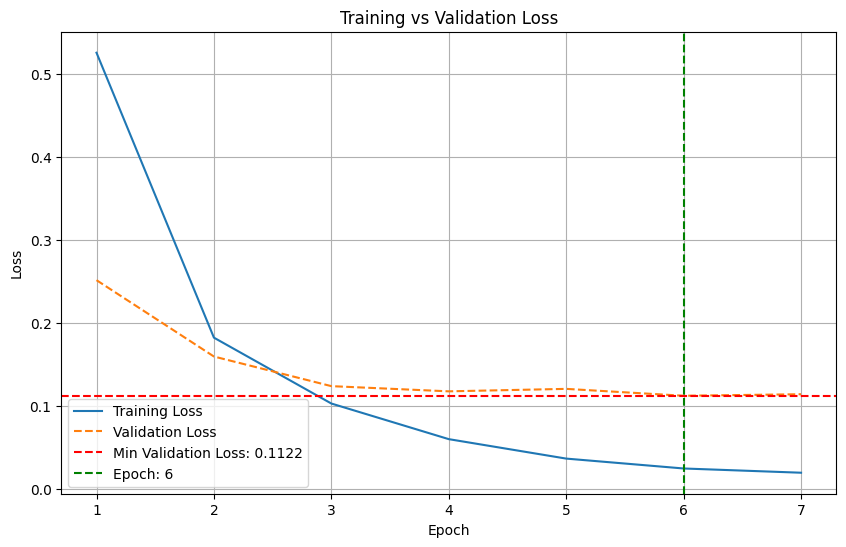

Macro-Averaged F1 Score: 0.4478

Micro-Averaged F1 Score: 0.6740

Weigthed-Averaged F1 Score: 0.6707

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     8         

I-AND Gateway                       0.0000     0.0000     0.0000     3         

B-Activity                          0.8739     0.8000     0.8353     130       

I-Activity                          1.0000     0.0769     0.1429     13        

B-Activity Data                     0.8073     0.7857     0.7964     112       

I-Activity Data                     0.6034     0.6796     0.6393     103       

B-Actor                             0.8913     0.7593     0.8200     108       

I-Actor                             0.7703     0.7808     0.7755     73        

B-Condition Specification           0.7500     0.4444     0.5581     27        

I-Condition Specification           0.3704     0.4000     0.3846     25        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.9078, Precision: 0.8311, Recall: 0.0904, F1: 0.1554
Step 50, Loss: 0.1904, Precision: 0.9056, Recall: 0.9332, F1: 0.9187
Average training loss: 0.5495

Macro-Averaged F1 Score: 0.1990

Micro-Averaged F1 Score: 0.4136

Weigthed-Averaged F1 Score: 0.3926

Epoch 2/7
Training...
Step 0, Loss: 0.2566, Precision: 0.9109, Recall: 0.9365, F1: 0.9233
Step 50, Loss: 0.1289, Precision: 0.9472, Recall: 0.9565, F1: 0.9498
Average training loss: 0.1603

Macro-Averaged F1 Score: 0.3447

Micro-Averaged F1 Score: 0.6407

Weigthed-Averaged F1 Score: 0.6177

Epoch 3/7
Training...
Step 0, Loss: 0.1517, Precision: 0.9533, Recall: 0.9556, F1: 0.9501
Step 50, Loss: 0.0418, Precision: 0.9593, Recall: 0.9614, F1: 0.9589
Average training loss: 0.0871

Macro-Averaged F1 Score: 0.4321

Micro-Averaged F1 Score: 0.6971

Weigthed-Averaged F1 Score: 0.6868

Epoch 4/7
Training...
Step 0, Loss: 0.0455, Precision: 0.9591, Recall: 0.9614, F1: 0.9590
Step 50, Loss: 0.0482, Precision: 

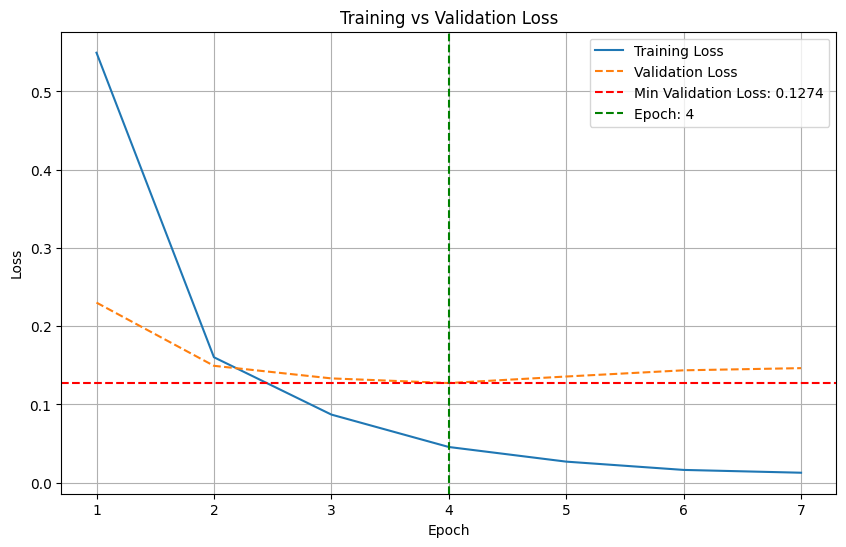

Macro-Averaged F1 Score: 0.5315

Micro-Averaged F1 Score: 0.7309

Weigthed-Averaged F1 Score: 0.7289

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     8         

I-AND Gateway                       0.0000     0.0000     0.0000     6         

B-Activity                          0.7714     0.9558     0.8538     113       

I-Activity                          0.6000     0.5000     0.5455     6         

B-Activity Data                     0.7656     0.9074     0.8305     108       

I-Activity Data                     0.5781     0.7957     0.6697     93        

B-Actor                             0.7669     0.8947     0.8259     114       

I-Actor                             0.7241     0.8750     0.7925     96        

B-Condition Specification           0.8182     0.6000     0.6923     30        

I-Condition Specification           0.5758     0.6333     0.6032     30        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.2422, Precision: 0.8406, Recall: 0.8950, F1: 0.8667
Step 50, Loss: 0.1296, Precision: 0.9321, Recall: 0.9475, F1: 0.9391
Average training loss: 0.3913

Macro-Averaged F1 Score: 0.2102

Micro-Averaged F1 Score: 0.4790

Weigthed-Averaged F1 Score: 0.4588

Epoch 2/7
Training...
Step 0, Loss: 0.1297, Precision: 0.9292, Recall: 0.9472, F1: 0.9373
Step 50, Loss: 0.1667, Precision: 0.9396, Recall: 0.9563, F1: 0.9460
Average training loss: 0.1215

Macro-Averaged F1 Score: 0.4056

Micro-Averaged F1 Score: 0.5905

Weigthed-Averaged F1 Score: 0.5718

Epoch 3/7
Training...
Step 0, Loss: 0.0637, Precision: 0.9415, Recall: 0.9581, F1: 0.9484
Step 50, Loss: 0.0999, Precision: 0.9616, Recall: 0.9642, F1: 0.9612
Average training loss: 0.0563

Macro-Averaged F1 Score: 0.4724

Micro-Averaged F1 Score: 0.6673

Weigthed-Averaged F1 Score: 0.6611

Epoch 4/7
Training...
Step 0, Loss: 0.0657, Precision: 0.9616, Recall: 0.9633, F1: 0.9608
Step 50, Loss: 0.0140, Precision: 

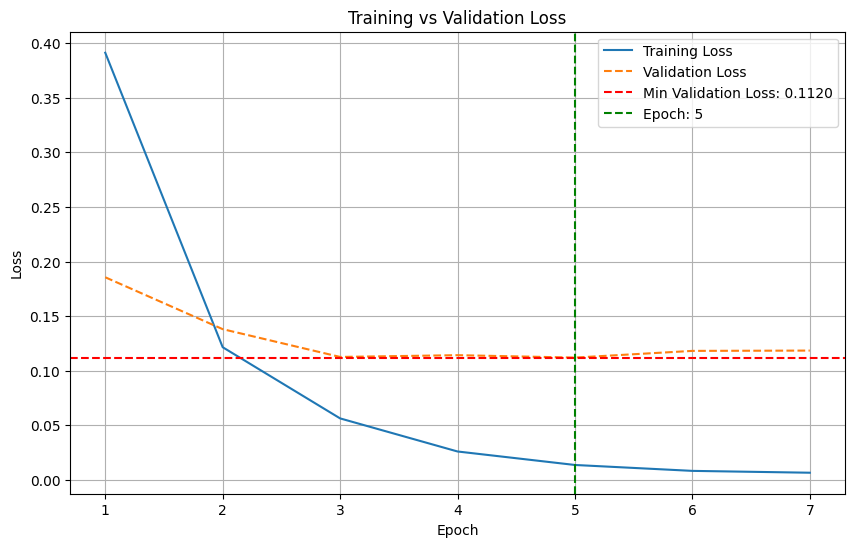

Macro-Averaged F1 Score: 0.5644

Micro-Averaged F1 Score: 0.7108

Weigthed-Averaged F1 Score: 0.7120

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.5000     0.1429     0.2222     7         

I-AND Gateway                       0.0000     0.0000     0.0000     3         

B-Activity                          0.8156     0.9350     0.8712     123       

I-Activity                          0.8333     0.4545     0.5882     11        

B-Activity Data                     0.7769     0.8393     0.8069     112       

I-Activity Data                     0.5442     0.7547     0.6324     106       

B-Actor                             0.8252     0.9043     0.8629     94        

I-Actor                             0.7128     0.8072     0.7571     83        

B-Condition Specification           1.0000     0.6667     0.8000     9         

I-Condition Specification           0.7500     0.6667     0.7059     9         

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.3732, Precision: 0.8333, Recall: 0.8951, F1: 0.8615
Step 50, Loss: 0.1909, Precision: 0.9410, Recall: 0.9514, F1: 0.9433
Average training loss: 0.3969

Macro-Averaged F1 Score: 0.2434

Micro-Averaged F1 Score: 0.5264

Weigthed-Averaged F1 Score: 0.5117

Epoch 2/7
Training...
Step 0, Loss: 0.1434, Precision: 0.9405, Recall: 0.9501, F1: 0.9416
Step 50, Loss: 0.1592, Precision: 0.9652, Recall: 0.9646, F1: 0.9640
Average training loss: 0.1170

Macro-Averaged F1 Score: 0.4475

Micro-Averaged F1 Score: 0.6992

Weigthed-Averaged F1 Score: 0.7011

Epoch 3/7
Training...
Step 0, Loss: 0.0479, Precision: 0.9658, Recall: 0.9650, F1: 0.9646
Step 50, Loss: 0.0477, Precision: 0.9669, Recall: 0.9669, F1: 0.9652
Average training loss: 0.0525

Macro-Averaged F1 Score: 0.5053

Micro-Averaged F1 Score: 0.7340

Weigthed-Averaged F1 Score: 0.7337

Epoch 4/7
Training...
Step 0, Loss: 0.0856, Precision: 0.9679, Recall: 0.9671, F1: 0.9661
Step 50, Loss: 0.0333, Precision: 

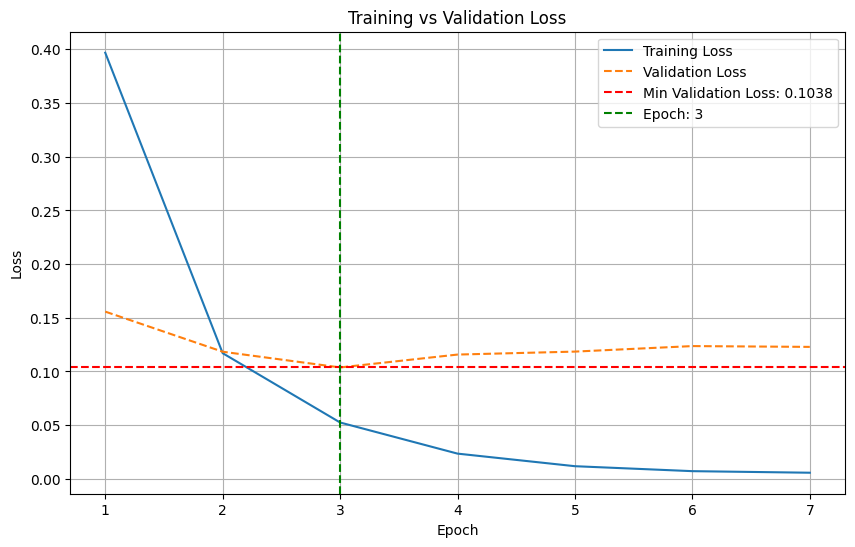

Macro-Averaged F1 Score: 0.6145

Micro-Averaged F1 Score: 0.7581

Weigthed-Averaged F1 Score: 0.7637

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       1.0000     0.4000     0.5714     5         

I-AND Gateway                       0.0000     0.0000     0.0000     1         

B-Activity                          0.9098     0.9024     0.9061     123       

I-Activity                          0.8889     1.0000     0.9412     8         

B-Activity Data                     0.8448     0.8167     0.8305     120       

I-Activity Data                     0.6512     0.7568     0.7000     111       

B-Actor                             0.8015     0.8203     0.8108     128       

I-Actor                             0.7073     0.7699     0.7373     113       

B-Condition Specification           0.5714     0.7273     0.6400     11        

I-Condition Specification           0.2917     0.6364     0.4000     11        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 3.1286, Precision: 0.8321, Recall: 0.0686, F1: 0.1241
Step 50, Loss: 0.2676, Precision: 0.9256, Recall: 0.9418, F1: 0.9329
Average training loss: 0.4888

Macro-Averaged F1 Score: 0.2067

Micro-Averaged F1 Score: 0.4578

Weigthed-Averaged F1 Score: 0.4278

Epoch 2/7
Training...
Step 0, Loss: 0.1992, Precision: 0.9297, Recall: 0.9417, F1: 0.9347
Step 50, Loss: 0.2244, Precision: 0.9559, Recall: 0.9600, F1: 0.9541
Average training loss: 0.1556

Macro-Averaged F1 Score: 0.3530

Micro-Averaged F1 Score: 0.6138

Weigthed-Averaged F1 Score: 0.5975

Epoch 3/7
Training...
Step 0, Loss: 0.1088, Precision: 0.9558, Recall: 0.9601, F1: 0.9549
Step 50, Loss: 0.1734, Precision: 0.9654, Recall: 0.9704, F1: 0.9672
Average training loss: 0.0888

Macro-Averaged F1 Score: 0.4610

Micro-Averaged F1 Score: 0.6974

Weigthed-Averaged F1 Score: 0.6936

Epoch 4/7
Training...
Step 0, Loss: 0.0645, Precision: 0.9659, Recall: 0.9709, F1: 0.9674
Step 50, Loss: 0.0193, Precision: 

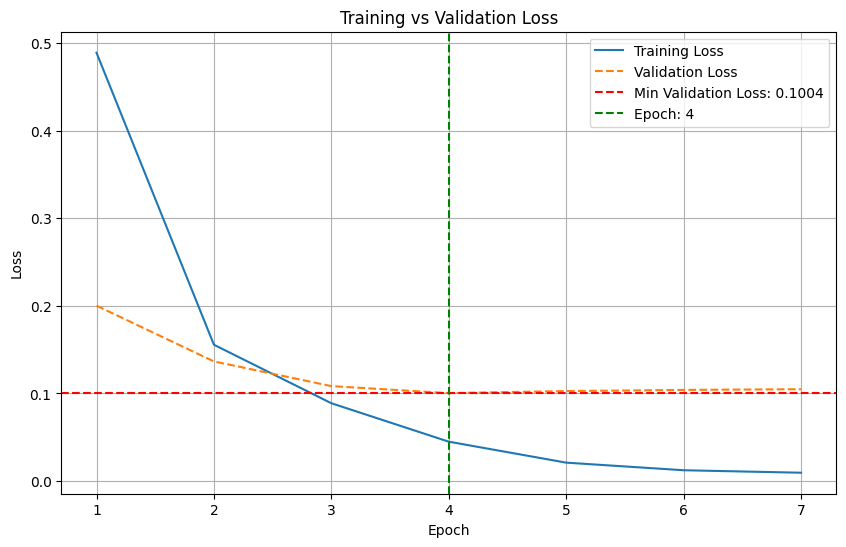

Macro-Averaged F1 Score: 0.5897

Micro-Averaged F1 Score: 0.7555

Weigthed-Averaged F1 Score: 0.7507

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     12        

I-AND Gateway                       0.0000     0.0000     0.0000     6         

B-Activity                          0.8298     0.9435     0.8830     124       

I-Activity                          1.0000     0.8333     0.9091     6         

B-Activity Data                     0.8095     0.8793     0.8430     116       

I-Activity Data                     0.5954     0.7723     0.6724     101       

B-Actor                             0.9300     0.9490     0.9394     98        

I-Actor                             0.7570     0.8710     0.8100     93        

B-Condition Specification           0.7500     0.5714     0.6486     21        

I-Condition Specification           0.5238     0.5500     0.5366     20        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.7972, Precision: 0.8803, Recall: 0.4934, F1: 0.6268
Step 50, Loss: 0.1670, Precision: 0.9351, Recall: 0.9462, F1: 0.9347
Average training loss: 0.4490

Macro-Averaged F1 Score: 0.2578

Micro-Averaged F1 Score: 0.4771

Weigthed-Averaged F1 Score: 0.4622

Epoch 2/7
Training...
Step 0, Loss: 0.1740, Precision: 0.9323, Recall: 0.9450, F1: 0.9326
Step 50, Loss: 0.0758, Precision: 0.9518, Recall: 0.9593, F1: 0.9530
Average training loss: 0.1240

Macro-Averaged F1 Score: 0.3528

Micro-Averaged F1 Score: 0.5903

Weigthed-Averaged F1 Score: 0.5803

Epoch 3/7
Training...
Step 0, Loss: 0.1188, Precision: 0.9532, Recall: 0.9602, F1: 0.9548
Step 50, Loss: 0.0307, Precision: 0.9628, Recall: 0.9651, F1: 0.9631
Average training loss: 0.0625

Macro-Averaged F1 Score: 0.4739

Micro-Averaged F1 Score: 0.6724

Weigthed-Averaged F1 Score: 0.6718

Epoch 4/7
Training...
Step 0, Loss: 0.0407, Precision: 0.9612, Recall: 0.9654, F1: 0.9625
Step 50, Loss: 0.0072, Precision: 

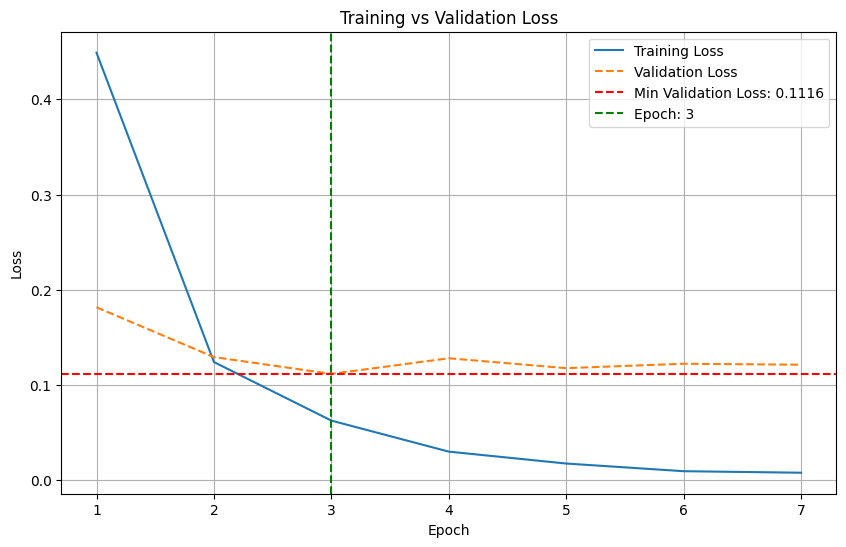

Macro-Averaged F1 Score: 0.5647

Micro-Averaged F1 Score: 0.6858

Weigthed-Averaged F1 Score: 0.6895

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.3333     0.1250     0.1818     8         

I-AND Gateway                       0.1667     0.3333     0.2222     3         

B-Activity                          0.8720     0.8385     0.8549     130       

I-Activity                          0.8333     0.3846     0.5263     13        

B-Activity Data                     0.7845     0.8125     0.7982     112       

I-Activity Data                     0.5772     0.6893     0.6283     103       

B-Actor                             0.8627     0.8148     0.8381     108       

I-Actor                             0.7229     0.8219     0.7692     73        

B-Condition Specification           1.0000     0.5185     0.6829     27        

I-Condition Specification           0.3636     0.4800     0.4138     25        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.8374, Precision: 0.8572, Recall: 0.3597, F1: 0.5018
Step 50, Loss: 0.2304, Precision: 0.8727, Recall: 0.9175, F1: 0.8866
Average training loss: 0.4691

Macro-Averaged F1 Score: 0.0533

Micro-Averaged F1 Score: 0.1271

Weigthed-Averaged F1 Score: 0.1148

Epoch 2/7
Training...
Step 0, Loss: 0.1555, Precision: 0.8826, Recall: 0.9220, F1: 0.8955
Step 50, Loss: 0.0988, Precision: 0.9432, Recall: 0.9538, F1: 0.9456
Average training loss: 0.1769

Macro-Averaged F1 Score: 0.2864

Micro-Averaged F1 Score: 0.5978

Weigthed-Averaged F1 Score: 0.5611

Epoch 3/7
Training...
Step 0, Loss: 0.1803, Precision: 0.9438, Recall: 0.9544, F1: 0.9464
Step 50, Loss: 0.1100, Precision: 0.9598, Recall: 0.9603, F1: 0.9572
Average training loss: 0.0969

Macro-Averaged F1 Score: 0.4080

Micro-Averaged F1 Score: 0.6873

Weigthed-Averaged F1 Score: 0.6728

Epoch 4/7
Training...
Step 0, Loss: 0.0594, Precision: 0.9599, Recall: 0.9604, F1: 0.9571
Step 50, Loss: 0.0436, Precision: 

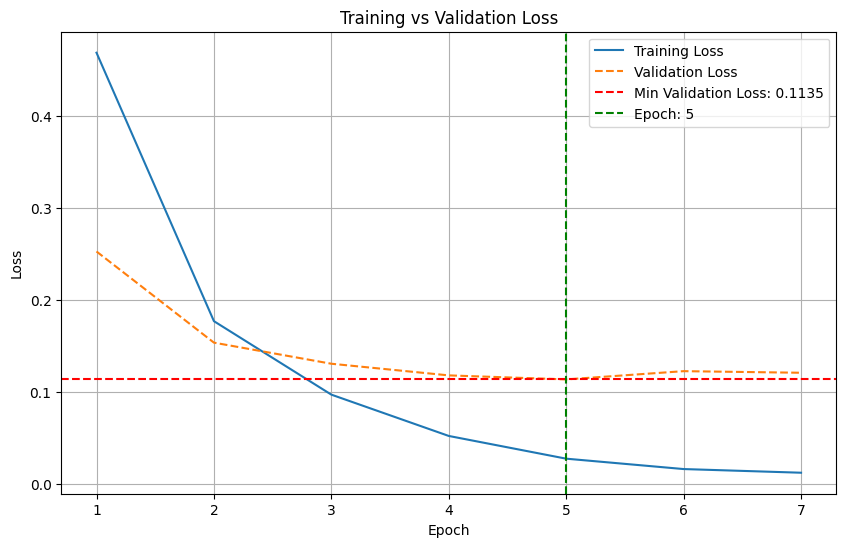

Macro-Averaged F1 Score: 0.5394

Micro-Averaged F1 Score: 0.7322

Weigthed-Averaged F1 Score: 0.7274

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     8         

I-AND Gateway                       0.0000     0.0000     0.0000     6         

B-Activity                          0.7899     0.9646     0.8685     113       

I-Activity                          0.8000     0.6667     0.7273     6         

B-Activity Data                     0.7984     0.9167     0.8534     108       

I-Activity Data                     0.5887     0.7849     0.6728     93        

B-Actor                             0.7934     0.8421     0.8170     114       

I-Actor                             0.7544     0.8958     0.8190     96        

B-Condition Specification           0.8462     0.7333     0.7857     30        

I-Condition Specification           0.5588     0.6333     0.5938     30        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.9022, Precision: 0.8573, Recall: 0.7927, F1: 0.8233
Step 50, Loss: 0.2766, Precision: 0.9226, Recall: 0.9436, F1: 0.9315
Average training loss: 0.4488

Macro-Averaged F1 Score: 0.1957

Micro-Averaged F1 Score: 0.3978

Weigthed-Averaged F1 Score: 0.3913

Epoch 2/7
Training...
Step 0, Loss: 0.1846, Precision: 0.9271, Recall: 0.9455, F1: 0.9353
Step 50, Loss: 0.0565, Precision: 0.9477, Recall: 0.9631, F1: 0.9548
Average training loss: 0.1485

Macro-Averaged F1 Score: 0.3669

Micro-Averaged F1 Score: 0.6490

Weigthed-Averaged F1 Score: 0.6192

Epoch 3/7
Training...
Step 0, Loss: 0.0885, Precision: 0.9481, Recall: 0.9634, F1: 0.9554
Step 50, Loss: 0.0603, Precision: 0.9640, Recall: 0.9688, F1: 0.9629
Average training loss: 0.0748

Macro-Averaged F1 Score: 0.4929

Micro-Averaged F1 Score: 0.7165

Weigthed-Averaged F1 Score: 0.6964

Epoch 4/7
Training...
Step 0, Loss: 0.0427, Precision: 0.9642, Recall: 0.9688, F1: 0.9630
Step 50, Loss: 0.0425, Precision: 

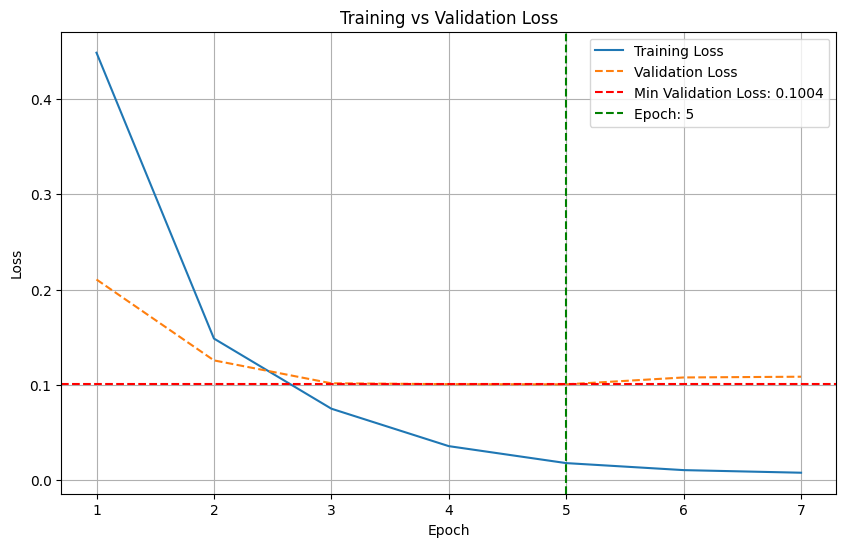

Macro-Averaged F1 Score: 0.5792

Micro-Averaged F1 Score: 0.7355

Weigthed-Averaged F1 Score: 0.7351

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       1.0000     0.1429     0.2500     7         

I-AND Gateway                       0.0000     0.0000     0.0000     3         

B-Activity                          0.8788     0.9431     0.9098     123       

I-Activity                          0.8333     0.4545     0.5882     11        

B-Activity Data                     0.7899     0.8393     0.8139     112       

I-Activity Data                     0.6612     0.7547     0.7048     106       

B-Actor                             0.8300     0.8830     0.8557     94        

I-Actor                             0.7527     0.8434     0.7955     83        

B-Condition Specification           1.0000     0.6667     0.8000     9         

I-Condition Specification           0.8571     0.6667     0.7500     9         

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.5794, Precision: 0.8271, Recall: 0.8748, F1: 0.8503
Step 50, Loss: 0.1652, Precision: 0.9519, Recall: 0.9577, F1: 0.9534
Average training loss: 0.3948

Macro-Averaged F1 Score: 0.3073

Micro-Averaged F1 Score: 0.6210

Weigthed-Averaged F1 Score: 0.6096

Epoch 2/7
Training...
Step 0, Loss: 0.1633, Precision: 0.9526, Recall: 0.9582, F1: 0.9541
Step 50, Loss: 0.1027, Precision: 0.9547, Recall: 0.9596, F1: 0.9548
Average training loss: 0.1081

Macro-Averaged F1 Score: 0.4071

Micro-Averaged F1 Score: 0.6635

Weigthed-Averaged F1 Score: 0.6575

Epoch 3/7
Training...
Step 0, Loss: 0.0847, Precision: 0.9543, Recall: 0.9594, F1: 0.9544
Step 50, Loss: 0.0284, Precision: 0.9657, Recall: 0.9665, F1: 0.9642
Average training loss: 0.0484

Macro-Averaged F1 Score: 0.5450

Micro-Averaged F1 Score: 0.7253

Weigthed-Averaged F1 Score: 0.7280

Epoch 4/7
Training...
Step 0, Loss: 0.0473, Precision: 0.9661, Recall: 0.9667, F1: 0.9644
Step 50, Loss: 0.0122, Precision: 

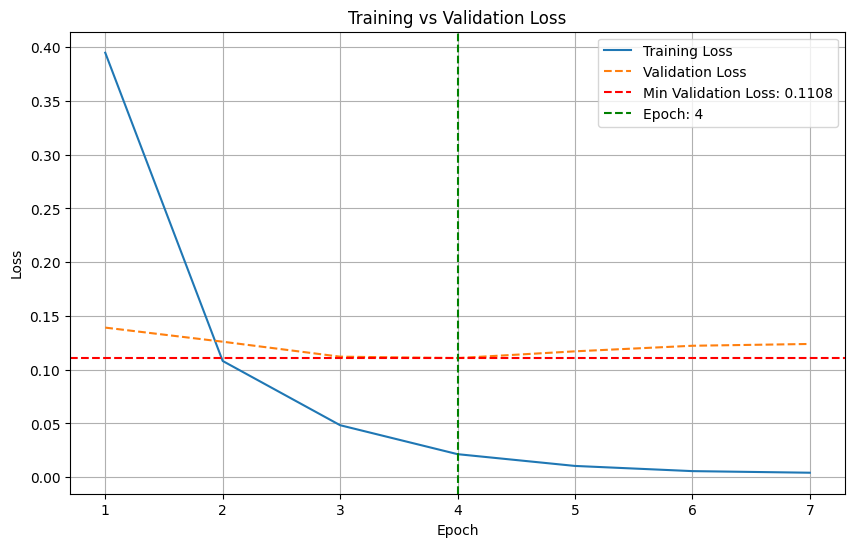

Macro-Averaged F1 Score: 0.6308

Micro-Averaged F1 Score: 0.7603

Weigthed-Averaged F1 Score: 0.7637

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       1.0000     0.4000     0.5714     5         

I-AND Gateway                       0.0000     0.0000     0.0000     1         

B-Activity                          0.8992     0.8699     0.8843     123       

I-Activity                          0.8889     1.0000     0.9412     8         

B-Activity Data                     0.8807     0.8000     0.8384     120       

I-Activity Data                     0.6299     0.7207     0.6723     111       

B-Actor                             0.8281     0.8281     0.8281     128       

I-Actor                             0.7143     0.7965     0.7531     113       

B-Condition Specification           0.5625     0.8182     0.6667     11        

I-Condition Specification           0.3333     0.7273     0.4571     11        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.9286, Precision: 0.8658, Recall: 0.5294, F1: 0.6558
Step 50, Loss: 0.1725, Precision: 0.9260, Recall: 0.9405, F1: 0.9316
Average training loss: 0.5008

Macro-Averaged F1 Score: 0.2115

Micro-Averaged F1 Score: 0.4345

Weigthed-Averaged F1 Score: 0.4279

Epoch 2/7
Training...
Step 0, Loss: 0.2303, Precision: 0.9235, Recall: 0.9434, F1: 0.9327
Step 50, Loss: 0.1268, Precision: 0.9644, Recall: 0.9688, F1: 0.9657
Average training loss: 0.1453

Macro-Averaged F1 Score: 0.4210

Micro-Averaged F1 Score: 0.6964

Weigthed-Averaged F1 Score: 0.6873

Epoch 3/7
Training...
Step 0, Loss: 0.0827, Precision: 0.9638, Recall: 0.9661, F1: 0.9639
Step 50, Loss: 0.0613, Precision: 0.9711, Recall: 0.9732, F1: 0.9710
Average training loss: 0.0681

Macro-Averaged F1 Score: 0.5100

Micro-Averaged F1 Score: 0.7403

Weigthed-Averaged F1 Score: 0.7342

Epoch 4/7
Training...
Step 0, Loss: 0.0676, Precision: 0.9706, Recall: 0.9737, F1: 0.9711
Step 50, Loss: 0.0236, Precision: 

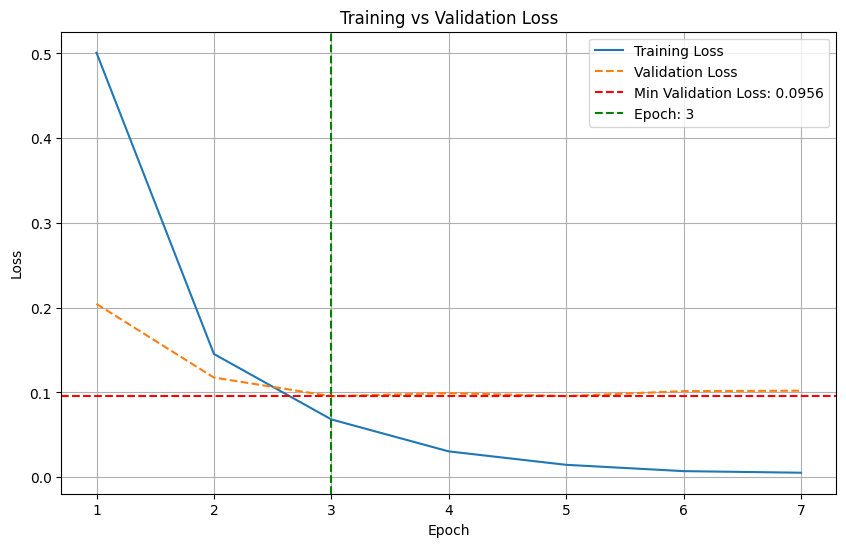

Macro-Averaged F1 Score: 0.5919

Micro-Averaged F1 Score: 0.7836

Weigthed-Averaged F1 Score: 0.7739

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     12        

I-AND Gateway                       0.0000     0.0000     0.0000     6         

B-Activity                          0.8519     0.9274     0.8880     124       

I-Activity                          1.0000     0.6667     0.8000     6         

B-Activity Data                     0.8655     0.8879     0.8766     116       

I-Activity Data                     0.7059     0.8317     0.7636     101       

B-Actor                             0.9216     0.9592     0.9400     98        

I-Actor                             0.8500     0.9140     0.8808     93        

B-Condition Specification           0.8125     0.6190     0.7027     21        

I-Condition Specification           0.5789     0.5500     0.5641     20        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.6914, Precision: 0.8434, Recall: 0.7247, F1: 0.7767
Step 50, Loss: 0.1105, Precision: 0.9291, Recall: 0.9424, F1: 0.9268
Average training loss: 0.3895

Macro-Averaged F1 Score: 0.2120

Micro-Averaged F1 Score: 0.4154

Weigthed-Averaged F1 Score: 0.3982

Epoch 2/7
Training...
Step 0, Loss: 0.1810, Precision: 0.9302, Recall: 0.9435, F1: 0.9284
Step 50, Loss: 0.1065, Precision: 0.9571, Recall: 0.9628, F1: 0.9579
Average training loss: 0.1034

Macro-Averaged F1 Score: 0.3857

Micro-Averaged F1 Score: 0.6257

Weigthed-Averaged F1 Score: 0.6175

Epoch 3/7
Training...
Step 0, Loss: 0.0987, Precision: 0.9588, Recall: 0.9635, F1: 0.9596
Step 50, Loss: 0.0091, Precision: 0.9643, Recall: 0.9681, F1: 0.9650
Average training loss: 0.0429

Macro-Averaged F1 Score: 0.5137

Micro-Averaged F1 Score: 0.6823

Weigthed-Averaged F1 Score: 0.6748

Epoch 4/7
Training...
Step 0, Loss: 0.0513, Precision: 0.9627, Recall: 0.9676, F1: 0.9635
Step 50, Loss: 0.0473, Precision: 

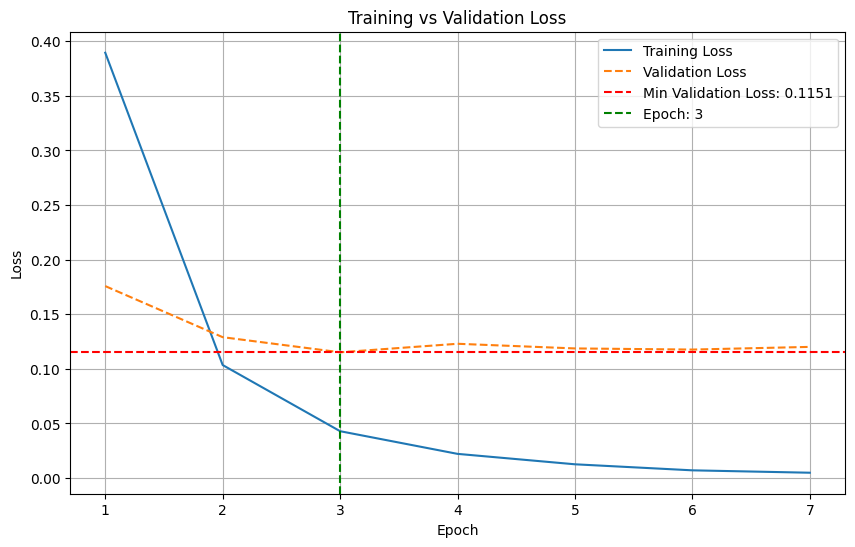

Macro-Averaged F1 Score: 0.6130

Micro-Averaged F1 Score: 0.7202

Weigthed-Averaged F1 Score: 0.7223

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       1.0000     0.2500     0.4000     8         

I-AND Gateway                       0.1111     0.3333     0.1667     3         

B-Activity                          0.8862     0.8385     0.8617     130       

I-Activity                          0.7143     0.3846     0.5000     13        

B-Activity Data                     0.7769     0.8393     0.8069     112       

I-Activity Data                     0.6053     0.6699     0.6359     103       

B-Actor                             0.8692     0.8611     0.8651     108       

I-Actor                             0.7662     0.8082     0.7867     73        

B-Condition Specification           0.8824     0.5556     0.6818     27        

I-Condition Specification           0.6087     0.5600     0.5833     25        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/7
Training...
Step 0, Loss: 2.7581, Precision: 0.8360, Recall: 0.7369, F1: 0.7828
Step 50, Loss: 0.1696, Precision: 0.9213, Recall: 0.9294, F1: 0.9231
Average training loss: 0.4381

Macro-Averaged F1 Score: 0.1889

Micro-Averaged F1 Score: 0.4223

Weigthed-Averaged F1 Score: 0.4112

Epoch 2/7
Training...
Step 0, Loss: 0.1361, Precision: 0.9258, Recall: 0.9269, F1: 0.9223
Step 50, Loss: 0.1307, Precision: 0.9521, Recall: 0.9557, F1: 0.9514
Average training loss: 0.1686

Macro-Averaged F1 Score: 0.3554

Micro-Averaged F1 Score: 0.6242

Weigthed-Averaged F1 Score: 0.6132

Epoch 3/7
Training...
Step 0, Loss: 0.0960, Precision: 0.9531, Recall: 0.9545, F1: 0.9512
Step 50, Loss: 0.1808, Precision: 0.9579, Recall: 0.9595, F1: 0.9575
Average training loss: 0.0835

Macro-Averaged F1 Score: 0.4539

Micro-Averaged F1 Score: 0.6657

Weigthed-Averaged F1 Score: 0.6650

Epoch 4/7
Training...
Step 0, Loss: 0.0427, Precision: 0.9578, Recall: 0.9596, F1: 0.9575
Step 50, Loss: 0.0269, Precision: 

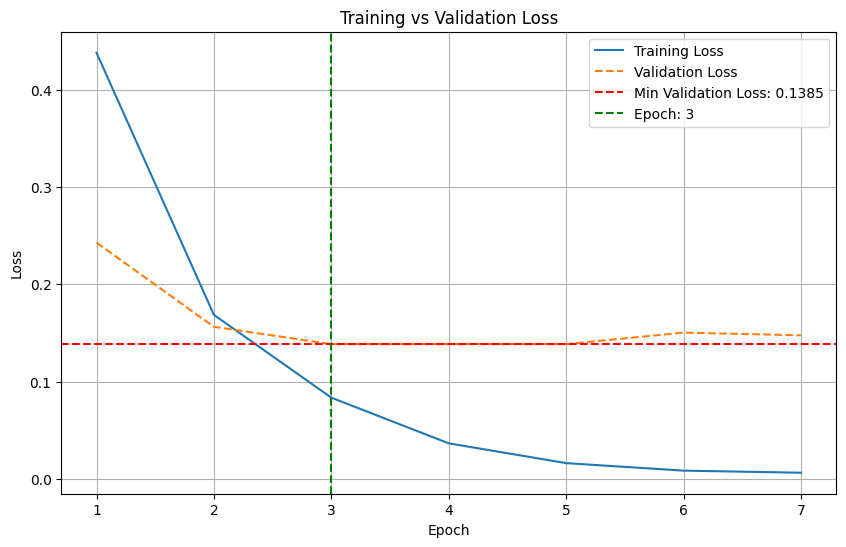

Macro-Averaged F1 Score: 0.5088

Micro-Averaged F1 Score: 0.7166

Weigthed-Averaged F1 Score: 0.7147

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.5000     0.1250     0.2000     8         

I-AND Gateway                       0.0000     0.0000     0.0000     6         

B-Activity                          0.7517     0.9646     0.8450     113       

I-Activity                          0.5000     0.5000     0.5000     6         

B-Activity Data                     0.7615     0.9167     0.8319     108       

I-Activity Data                     0.5606     0.7957     0.6578     93        

B-Actor                             0.8080     0.8860     0.8452     114       

I-Actor                             0.7611     0.8958     0.8230     96        

B-Condition Specification           0.8000     0.6667     0.7273     30        

I-Condition Specification           0.4722     0.5667     0.5152     30        

B-Furth

In [ ]:
learning_rates = [2e-5, 3e-5, 4e-5, 5e-5]
result_lr = {}

for lr in learning_rates:
    print("\n---------------------------------------")
    print(f"Learning Rate: {lr}")
    print("---------------------------------------\n")
    lr_model, avg_macro_f1, avg_micro_f1, avg_weight_f1, label_f1 = grouped_k_fold_cross_validation(input_data, 5, BATCH_SIZE, EPOCHS, label_map, lr)

    # Initialize the entry for this learning rate
    result_lr[lr] = {'avg_macro_f1': avg_macro_f1, 'avg_micro_f1':avg_micro_f1, 'avg_weight_f1': avg_weight_f1,  'label_f1': {}}

    for label, scores in label_f1.items():
        try:
            average_f1 = sum(scores) / len(scores)
            result_lr[lr]['label_f1'][label] = average_f1
        except ZeroDivisionError as zero:
            print(f"Zero division error for label {label}")

# Print the result to verify
print(result_lr)


In [ ]:
for item in result_lr:
  print('Learning rate:', item)
  print('macro avg f1 for all folds: ', round(result_lr[item]['avg_macro_f1'],4))
  print('micro avg f1 for all folds: ', round(result_lr[item]['avg_micro_f1'],4))
  print('weighted avg f1 for all folds: ', round(result_lr[item]['avg_weight_f1'],4))
  for label, score in result_lr[item]['label_f1'].items():
    if label.startswith("B-AND") or label.startswith("I-AND"):
      print(label, round(score,2))
  print('----')

Learning rate: 2e-05
macro avg f1 for all folds:  0.4826
micro avg f1 for all folds:  0.7094
weighted avg f1 for all folds:  0.7015
B-AND Gateway 0.0
I-AND Gateway 0.0
----
Learning rate: 3e-05
macro avg f1 for all folds:  0.5167
micro avg f1 for all folds:  0.7185
weighted avg f1 for all folds:  0.7159
B-AND Gateway 0.12
I-AND Gateway 0.0
----
Learning rate: 4e-05
macro avg f1 for all folds:  0.5745
micro avg f1 for all folds:  0.7285
weighted avg f1 for all folds:  0.7287
B-AND Gateway 0.2
I-AND Gateway 0.04
----
Learning rate: 5e-05
macro avg f1 for all folds:  0.5847
micro avg f1 for all folds:  0.7432
weighted avg f1 for all folds:  0.7419
B-AND Gateway 0.28
I-AND Gateway 0.03
----


Fold 1


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/6
Training...
Step 0, Loss: 2.5006, Precision: 0.8477, Recall: 0.9035, F1: 0.8747
Step 50, Loss: 0.1906, Precision: 0.9458, Recall: 0.9564, F1: 0.9506
Average training loss: 0.3784

Macro-Averaged F1 Score: 0.2591

Micro-Averaged F1 Score: 0.5813

Weigthed-Averaged F1 Score: 0.5559

Epoch 2/6
Training...
Step 0, Loss: 0.1358, Precision: 0.9458, Recall: 0.9569, F1: 0.9509
Step 50, Loss: 0.1306, Precision: 0.9581, Recall: 0.9648, F1: 0.9581
Average training loss: 0.1078

Macro-Averaged F1 Score: 0.4295

Micro-Averaged F1 Score: 0.6408

Weigthed-Averaged F1 Score: 0.6288

Epoch 3/6
Training...
Step 0, Loss: 0.0677, Precision: 0.9590, Recall: 0.9654, F1: 0.9587
Step 50, Loss: 0.0372, Precision: 0.9639, Recall: 0.9698, F1: 0.9654
Average training loss: 0.0483

Macro-Averaged F1 Score: 0.4970

Micro-Averaged F1 Score: 0.7075

Weigthed-Averaged F1 Score: 0.7006

Epoch 4/6
Training...
Step 0, Loss: 0.0716, Precision: 0.9645, Recall: 0.9698, F1: 0.9661
Step 50, Loss: 0.0159, Precision: 

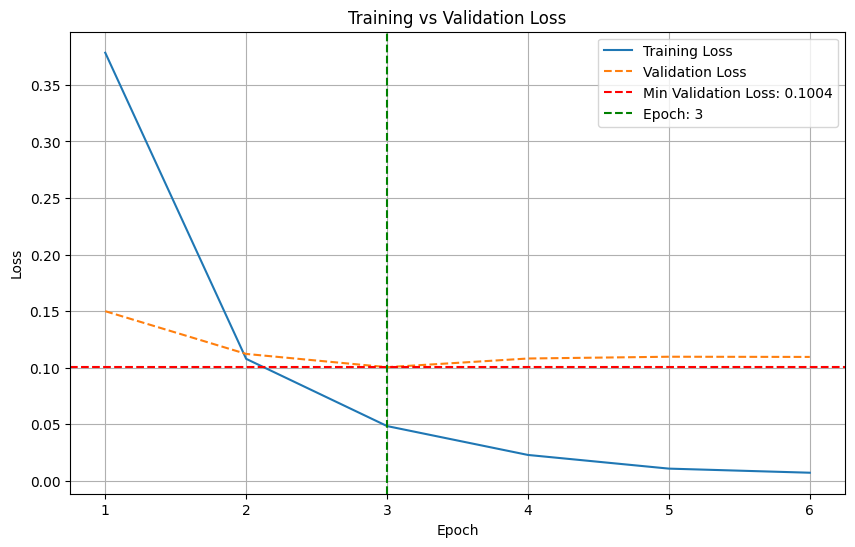

Macro-Averaged F1 Score: 0.5564

Micro-Averaged F1 Score: 0.7033

Weigthed-Averaged F1 Score: 0.7027

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       1.0000     0.2500     0.4000     8         

I-AND Gateway                       0.0000     0.0000     0.0000     2         

B-Activity                          0.8609     0.9429     0.9000     105       

I-Activity                          1.0000     0.4286     0.6000     7         

B-Activity Data                     0.7941     0.8100     0.8020     100       

I-Activity Data                     0.5574     0.7158     0.6267     95        

B-Actor                             0.8053     0.9010     0.8505     101       

I-Actor                             0.7143     0.8721     0.7853     86        

B-Condition Specification           0.8333     0.6250     0.7143     8         

I-Condition Specification           0.7143     0.6250     0.6667     8         

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/6
Training...
Step 0, Loss: 2.7847, Precision: 0.8477, Recall: 0.7388, F1: 0.7880
Step 50, Loss: 0.2003, Precision: 0.9174, Recall: 0.9378, F1: 0.9209
Average training loss: 0.4163

Macro-Averaged F1 Score: 0.1843

Micro-Averaged F1 Score: 0.3995

Weigthed-Averaged F1 Score: 0.3814

Epoch 2/6
Training...
Step 0, Loss: 0.2230, Precision: 0.9192, Recall: 0.9397, F1: 0.9238
Step 50, Loss: 0.1655, Precision: 0.9652, Recall: 0.9697, F1: 0.9650
Average training loss: 0.1402

Macro-Averaged F1 Score: 0.4079

Micro-Averaged F1 Score: 0.7051

Weigthed-Averaged F1 Score: 0.6919

Epoch 3/6
Training...
Step 0, Loss: 0.0701, Precision: 0.9655, Recall: 0.9700, F1: 0.9652
Step 50, Loss: 0.0466, Precision: 0.9717, Recall: 0.9708, F1: 0.9703
Average training loss: 0.0679

Macro-Averaged F1 Score: 0.5216

Micro-Averaged F1 Score: 0.7361

Weigthed-Averaged F1 Score: 0.7425

Epoch 4/6
Training...
Step 0, Loss: 0.0852, Precision: 0.9719, Recall: 0.9707, F1: 0.9704
Step 50, Loss: 0.0359, Precision: 

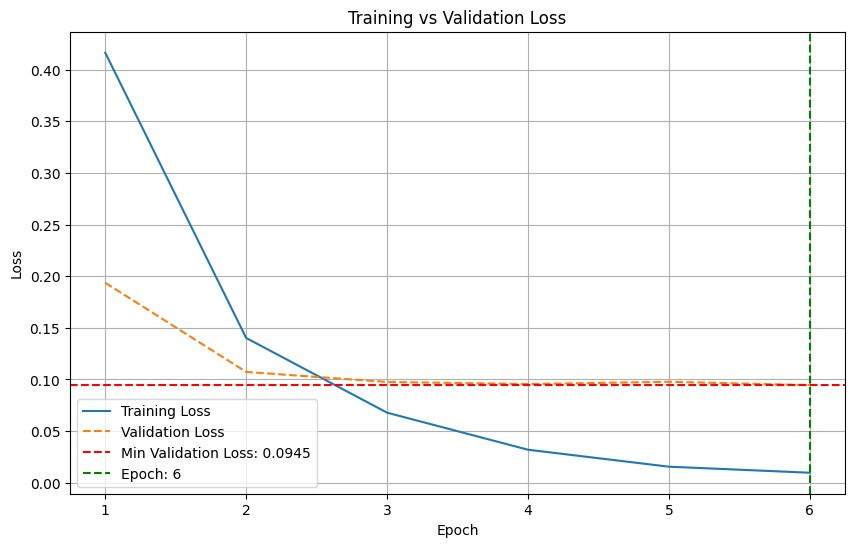

Macro-Averaged F1 Score: 0.5919

Micro-Averaged F1 Score: 0.7623

Weigthed-Averaged F1 Score: 0.7666

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     7         

I-AND Gateway                       0.2000     0.2500     0.2222     4         

B-Activity                          0.9343     0.9412     0.9377     136       

I-Activity                          0.9091     0.8333     0.8696     12        

B-Activity Data                     0.9115     0.7923     0.8477     130       

I-Activity Data                     0.7059     0.7179     0.7119     117       

B-Actor                             0.8839     0.8534     0.8684     116       

I-Actor                             0.6909     0.7755     0.7308     98        

B-Condition Specification           0.9000     0.5625     0.6923     16        

I-Condition Specification           0.6364     0.4375     0.5185     16        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/6
Training...
Step 0, Loss: 2.8714, Precision: 0.8494, Recall: 0.6134, F1: 0.7113
Step 50, Loss: 0.2152, Precision: 0.9424, Recall: 0.9512, F1: 0.9459
Average training loss: 0.4046

Macro-Averaged F1 Score: 0.3118

Micro-Averaged F1 Score: 0.5845

Weigthed-Averaged F1 Score: 0.5617

Epoch 2/6
Training...
Step 0, Loss: 0.1633, Precision: 0.9433, Recall: 0.9495, F1: 0.9452
Step 50, Loss: 0.0995, Precision: 0.9555, Recall: 0.9629, F1: 0.9564
Average training loss: 0.1032

Macro-Averaged F1 Score: 0.4567

Micro-Averaged F1 Score: 0.6861

Weigthed-Averaged F1 Score: 0.6717

Epoch 3/6
Training...
Step 0, Loss: 0.1013, Precision: 0.9595, Recall: 0.9638, F1: 0.9592
Step 50, Loss: 0.0143, Precision: 0.9591, Recall: 0.9639, F1: 0.9607
Average training loss: 0.0510

Macro-Averaged F1 Score: 0.5187

Micro-Averaged F1 Score: 0.7025

Weigthed-Averaged F1 Score: 0.6971

Epoch 4/6
Training...
Step 0, Loss: 0.0733, Precision: 0.9593, Recall: 0.9641, F1: 0.9609
Step 50, Loss: 0.0116, Precision: 

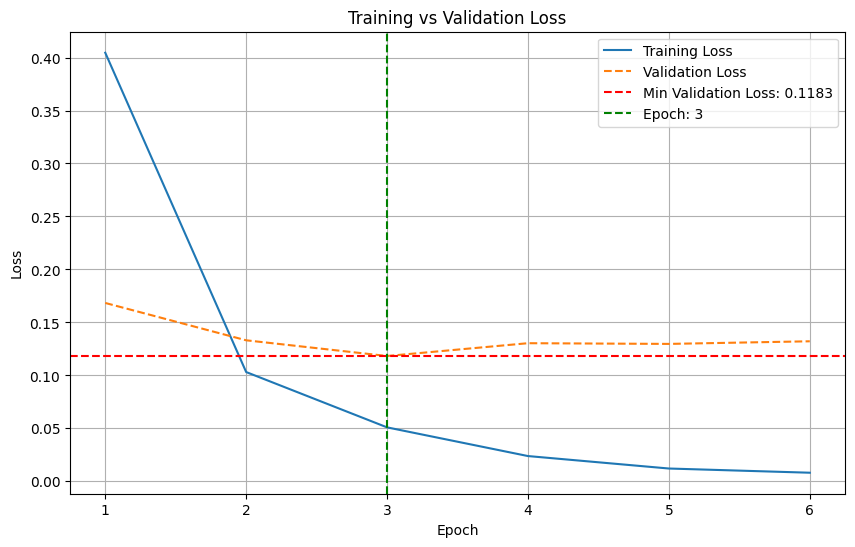

Macro-Averaged F1 Score: 0.5991

Micro-Averaged F1 Score: 0.7388

Weigthed-Averaged F1 Score: 0.7387

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.0000     0.0000     0.0000     13        

I-AND Gateway                       0.0000     0.0000     0.0000     6         

B-Activity                          0.8702     0.8906     0.8803     128       

I-Activity                          0.7778     0.7778     0.7778     9         

B-Activity Data                     0.7752     0.8475     0.8097     118       

I-Activity Data                     0.6694     0.7788     0.7200     104       

B-Actor                             0.7982     0.8788     0.8365     99        

I-Actor                             0.7553     0.8353     0.7933     85        

B-Condition Specification           0.7600     0.7917     0.7755     24        

I-Condition Specification           0.5405     0.8696     0.6667     23        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/6
Training...
Step 0, Loss: 2.6895, Precision: 0.8246, Recall: 0.8676, F1: 0.8453
Step 50, Loss: 0.1017, Precision: 0.9372, Recall: 0.9542, F1: 0.9449
Average training loss: 0.3756

Macro-Averaged F1 Score: 0.2672

Micro-Averaged F1 Score: 0.5707

Weigthed-Averaged F1 Score: 0.5439

Epoch 2/6
Training...
Step 0, Loss: 0.1771, Precision: 0.9391, Recall: 0.9531, F1: 0.9454
Step 50, Loss: 0.0949, Precision: 0.9558, Recall: 0.9620, F1: 0.9559
Average training loss: 0.1024

Macro-Averaged F1 Score: 0.4110

Micro-Averaged F1 Score: 0.6609

Weigthed-Averaged F1 Score: 0.6473

Epoch 3/6
Training...
Step 0, Loss: 0.0663, Precision: 0.9558, Recall: 0.9619, F1: 0.9558
Step 50, Loss: 0.0484, Precision: 0.9608, Recall: 0.9643, F1: 0.9610
Average training loss: 0.0463

Macro-Averaged F1 Score: 0.5525

Micro-Averaged F1 Score: 0.6794

Weigthed-Averaged F1 Score: 0.6810

Epoch 4/6
Training...
Step 0, Loss: 0.0254, Precision: 0.9608, Recall: 0.9645, F1: 0.9611
Step 50, Loss: 0.0217, Precision: 

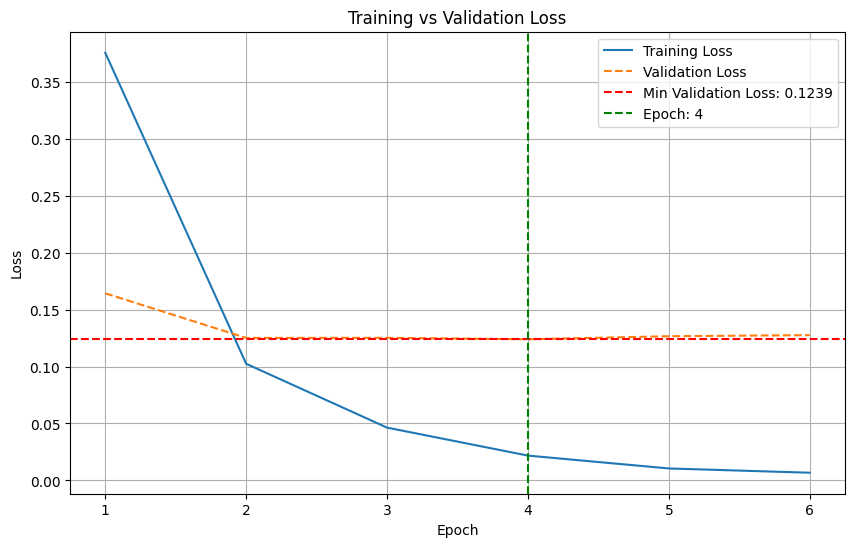

Macro-Averaged F1 Score: 0.6025

Micro-Averaged F1 Score: 0.7101

Weigthed-Averaged F1 Score: 0.7152

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.5000     0.2000     0.2857     5         

I-AND Gateway                       0.0000     0.0000     0.0000     2         

B-Activity                          0.8810     0.8672     0.8740     128       

I-Activity                          0.8333     0.5000     0.6250     10        

B-Activity Data                     0.7982     0.8349     0.8161     109       

I-Activity Data                     0.5763     0.6869     0.6267     99        

B-Actor                             0.8898     0.8537     0.8714     123       

I-Actor                             0.8200     0.8723     0.8454     94        

B-Condition Specification           0.7368     0.6364     0.6829     22        

I-Condition Specification           0.4074     0.5500     0.4681     20        

B-Furth

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/6
Training...
Step 0, Loss: 2.9927, Precision: 0.8563, Recall: 0.2205, F1: 0.3495
Step 50, Loss: 0.1592, Precision: 0.9275, Recall: 0.9459, F1: 0.9357
Average training loss: 0.4488

Macro-Averaged F1 Score: 0.2405

Micro-Averaged F1 Score: 0.5417

Weigthed-Averaged F1 Score: 0.5069

Epoch 2/6
Training...
Step 0, Loss: 0.1484, Precision: 0.9300, Recall: 0.9452, F1: 0.9362
Step 50, Loss: 0.1255, Precision: 0.9530, Recall: 0.9633, F1: 0.9562
Average training loss: 0.1373

Macro-Averaged F1 Score: 0.4025

Micro-Averaged F1 Score: 0.6840

Weigthed-Averaged F1 Score: 0.6709

Epoch 3/6
Training...
Step 0, Loss: 0.1057, Precision: 0.9549, Recall: 0.9647, F1: 0.9579
Step 50, Loss: 0.0475, Precision: 0.9686, Recall: 0.9716, F1: 0.9687
Average training loss: 0.0680

Macro-Averaged F1 Score: 0.4988

Micro-Averaged F1 Score: 0.7396

Weigthed-Averaged F1 Score: 0.7318

Epoch 4/6
Training...
Step 0, Loss: 0.0445, Precision: 0.9688, Recall: 0.9710, F1: 0.9682
Step 50, Loss: 0.0219, Precision: 

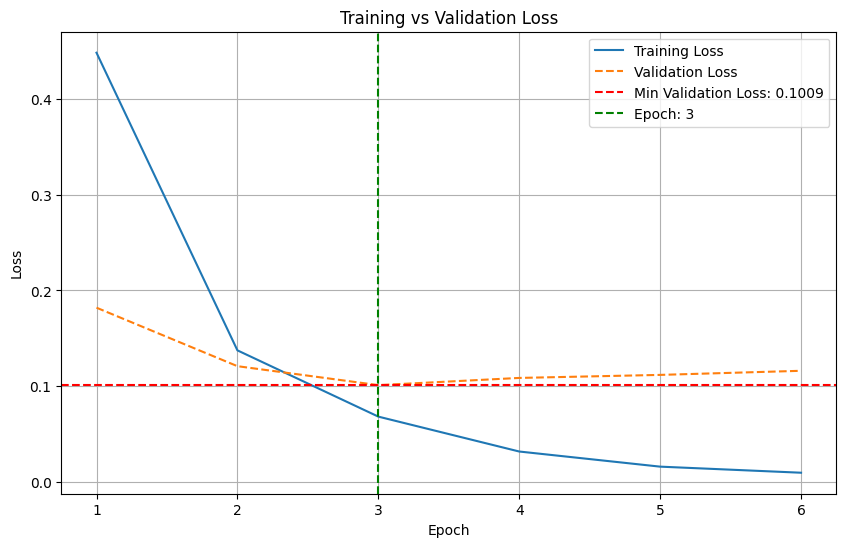

Macro-Averaged F1 Score: 0.5543

Micro-Averaged F1 Score: 0.7542

Weigthed-Averaged F1 Score: 0.7487

Label                               Precision  Recall     F1         Support   

B-AND Gateway                       0.5000     0.1429     0.2222     7         

I-AND Gateway                       0.0000     0.0000     0.0000     5         

B-Activity                          0.7857     0.9483     0.8594     116       

I-Activity                          0.6667     0.6667     0.6667     6         

B-Activity Data                     0.7846     0.9189     0.8465     111       

I-Activity Data                     0.6015     0.8081     0.6897     99        

B-Actor                             0.8636     0.9223     0.8920     103       

I-Actor                             0.8113     0.9053     0.8557     95        

B-Condition Specification           0.7500     0.6429     0.6923     28        

I-Condition Specification           0.4706     0.5714     0.5161     28        

B-Furth

In [ ]:
epoch_best = 6 #DONE

learning_rate = 5e-05
best_model, avg_macro_f1, avg_micro_f1, avg_weight_f1, label_f1 = grouped_k_fold_cross_validation(input_data, 5, BATCH_SIZE, epoch_best, label_map, learning_rate)


To train on the (whole) dataset, save the model and download it for later use without having to retrain the model. Uncomment for it to work.

#3. Model Saving for Pipeline

First we need to create a subset of the data to keep separate documents for testing. These documents are then also removed from the original training data before it goes through training.

##3.1.1 Remove 6 documents for testing


In [ ]:
#@title Training Model
def train_model_pipeline(input_data_pipeline, BATCH_SIZE, EPOCHS, label_map, learning_rate):
  # Training of the model
  # Instantiate the dataset and dataloader for validation
  train_data, val_data = train_test_split(input_data_pipeline, test_size=0.2, random_state=SEED)

  train_dataset = NERDataset(
      sentences=[entry['tokens'] for entry in train_data],
      labels=[entry['ner-tags'] for entry in train_data],
      tokenizer=tokenizer,
      max_len=MAX_LEN,
      label_map=label_map
  )
  # Instantiate the dataset and dataloader for validation
  val_dataset = NERDataset(
      sentences=[entry['tokens'] for entry in val_data],
      labels=[entry['ner-tags'] for entry in val_data],
      tokenizer=tokenizer,
      max_len=MAX_LEN,
      label_map=label_map
  )

  #Initialize the DataLoader objects
  train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

  #loading the desired model: each fold we need start fresh
  model = BertForTokenClassification.from_pretrained("bert-base-cased", num_labels=NUM_LABELS)

  # Fine-tuning setup, can be changed for model optimisation
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, eps=1e-8)
  total_steps = len(train_loader) * EPOCHS
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

  # Using funtion defined above to train the model and obtain the losses for plotting at the same time
  model, training_losses, validation_losses = train_model(model, train_loader, val_loader, optimizer, scheduler, EPOCHS, label_map)
  plot_losses(training_losses,validation_losses)

  #Evaluating the model in this fold
  val_metrics = evaluate_model(model, val_loader, label_map)

  #So it is printed pretty :)
  header = "{:<35} {:<10} {:<10} {:<10}\n".format("Label", "Precision", "Recall", "F1")
  row_format = "{:<35} {:<10} {:<10} {:<10}\n"
  print(header)
  for label, metrics in val_metrics['detailed_metrics'].items():
    print(row_format.format(label, "{:.4f}".format(metrics['precision']), "{:.4f}".format(metrics['recall']), "{:.4f}".format(metrics['f1'])))

  # Now, label_f1_scores[label] holds a list of F1 scores for that label across all folds
  return model

Based on the testing on proper learning rates and looking at the loss graphs we set the epochs to 5 and the lr to ```5e-05```.

{'doc-3.1', 'doc-10.7', 'doc-9.3', 'doc-10.12', 'doc-8.2', 'doc-20.5 - edit pictures'}
data loaded


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/6
Training...
Step 0, Loss: 2.5135, Precision: 0.8307, Recall: 0.8949, F1: 0.8610
Step 47, Loss: 0.1597, Precision: 0.9381, Recall: 0.9499, F1: 0.9398
Average training loss: 0.3851

Macro-Averaged F1 Score: 0.2554

Micro-Averaged F1 Score: 0.5292

Weigthed-Averaged F1 Score: 0.4999

Epoch 2/6
Training...
Step 0, Loss: 0.1594, Precision: 0.9361, Recall: 0.9499, F1: 0.9390
Step 47, Loss: 0.0650, Precision: 0.9619, Recall: 0.9631, F1: 0.9600
Average training loss: 0.1109

Macro-Averaged F1 Score: 0.4599

Micro-Averaged F1 Score: 0.6757

Weigthed-Averaged F1 Score: 0.6696

Epoch 3/6
Training...
Step 0, Loss: 0.0507, Precision: 0.9625, Recall: 0.9638, F1: 0.9609
Step 47, Loss: 0.0514, Precision: 0.9646, Recall: 0.9666, F1: 0.9643
Average training loss: 0.0490

Macro-Averaged F1 Score: 0.5573

Micro-Averaged F1 Score: 0.7012

Weigthed-Averaged F1 Score: 0.6956

Epoch 4/6
Training...
Step 0, Loss: 0.0287, Precision: 0.9644, Recall: 0.9663, F1: 0.9642
Step 47, Loss: 0.0332, Precision: 

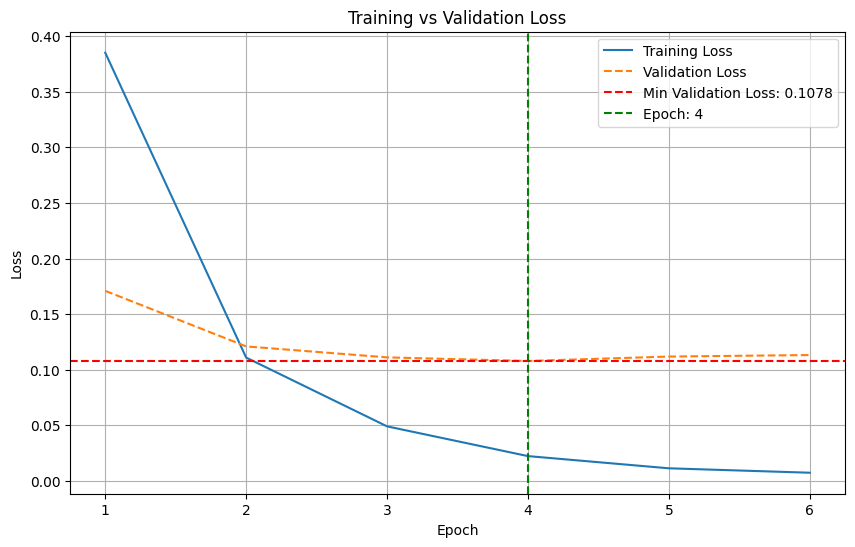

Macro-Averaged F1 Score: 0.6319

Micro-Averaged F1 Score: 0.7389

Weigthed-Averaged F1 Score: 0.7355

Label                               Precision  Recall     F1        

I-AND Gateway                       0.0000     0.0000     0.0000    

I-Activity Data                     0.5812     0.7234     0.6445    

I-XOR Gateway                       1.0000     1.0000     1.0000    

I-Actor                             0.8085     0.9268     0.8636    

B-XOR Gateway                       0.9583     0.7419     0.8364    

I-Condition Specification           0.6190     0.6500     0.6341    

B-Further Specification             1.0000     0.2778     0.4348    

B-Activity                          0.8115     0.8684     0.8390    

B-Actor                             0.8585     0.9100     0.8835    

O                                   0.6361     0.7138     0.6727    

B-Condition Specification           0.8333     0.7143     0.7692    

B-Activity Data                     0.7788     0.8224     

In [ ]:
def pick_and_remove_documents(data, num_docs, SEED):
    # Pick 6 documents at random
    random.seed(SEED)
    selected_docs_indices = random.sample(range(len(data)), num_docs)
    selected_docs = [data[i] for i in selected_docs_indices]

    # Remove the selected documents from the original data
    remaining_docs = [doc for i, doc in enumerate(data) if i not in selected_docs_indices]

    return selected_docs, remaining_docs

try:

  selected_docs, remaining_docs = pick_and_remove_documents(unflattened_data, 6, SEED)
  folder_path = '/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/TESTING DATA/NER_TESTING/'

  check= set()
  for document in selected_docs:
    for sentence in document:
      check.add(sentence['document name'])
  print(check)

  # here the selected documents are saved for pipeline testing
  for i, document in enumerate(selected_docs):
        file_path = os.path.join(folder_path, f'document_{i+1}.json')
        with open(file_path, 'w') as file:
            for sentence in document:
                # Convert the sentence to a JSON string and write it with a newline
                json_line = json.dumps(sentence) + '\n'
                file.write(json_line)

  input_data_pipeline = [item for group in remaining_docs for item in group]

  if input_data_pipeline:
    print('data loaded')

  #training of the model without the 6 left out documents
  epochs_pipe= 6 #checked
  lr= 5e-05
  model2 = train_model_pipeline(input_data_pipeline, BATCH_SIZE, epochs_pipe, label_map, lr)

except FileNotFoundError as fnf:
  print("File was not found or incorrect file directory, please try to run cell again")

##3.2 Training and saving the model



In [ ]:
# Save the model to a file
# Assuming 'best_model' is your trained model and 'tokenizer' is your tokenizer
model_path = "/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/PIPELINE/NER MODELS/BERT_base_cased/6DOCLEFTOUT/MODEL/"
tokenizer_path = "/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/PIPELINE/NER MODELS/BERT_base_cased/6DOCLEFTOUT/TOKENIZER/"

# Save the model & tokenizer
model2.save_pretrained(model_path)
tokenizer.save_pretrained(tokenizer_path)

('/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/PIPELINE/NER MODELS/BERT_base_cased/6DOCLEFTOUT/TOKENIZER/tokenizer_config.json',
 '/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/PIPELINE/NER MODELS/BERT_base_cased/6DOCLEFTOUT/TOKENIZER/special_tokens_map.json',
 '/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/PIPELINE/NER MODELS/BERT_base_cased/6DOCLEFTOUT/TOKENIZER/vocab.txt',
 '/content/drive/MyDrive/THESIS/CODING/NAM_TESTING/PIPELINE/NER MODELS/BERT_base_cased/6DOCLEFTOUT/TOKENIZER/added_tokens.json')